# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(f'using {device} device')

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


mkdir: cannot create directory ‘results’: File exists
using cuda device


# Neural Network class

* Generator
* Discriminator


In [ ]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(20, 400)  
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):

        x = F.relu(self.fc1(z.view(-1, 20)))
        probabilities = F.sigmoid(self.fc2(x)).to(device)
        
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, 400)   
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):

        x = F.relu(self.fc1(x.view(-1, 784)))
        probabilities = F.sigmoid(self.fc2(x)).to(device)
        
        return probabilities

# Loss Function

In [ ]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):

    criterion = nn.BCELoss()
    BCE = criterion(predictions, targets)

    return BCE

# Training

In [ ]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0

In [ ]:
# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):

    G_losses = []
    D_losses = []
    iters = 0

    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = gan_loss_function(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 20, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = gan_loss_function(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = gan_loss_function(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

    average_discriminator_loss = sum(D_losses)/ len(D_losses)
    average_generator_loss = sum(G_losses)/ len(G_losses)
    return average_generator_loss, average_discriminator_loss


# Testing


In [ ]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):

    G_losses = []
    D_losses = []
    iters = 0

    for i, data in enumerate(test_loader, 0):
        with torch.no_grad():
            
            ############################
            # (1) D network
            ###########################
            ## Test with all-real batch
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = discriminator(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = gan_loss_function(output, label)
            D_x = output.mean().item()

            ## Test with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, 20, 1, 1, device=device)
            # Generate fake image batch with G
            fake = generator(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = discriminator(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = gan_loss_function(output, label)
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake

            ############################
            # (2) G network
            ###########################

            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = discriminator(fake).view(-1)
            # Calculate G's loss based on this output
            errG = gan_loss_function(output, label)
            D_G_z2 = output.mean().item()

            # Output testing stats
            if i % 50 == 0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (i, len(test_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1

    average_discriminator_loss = sum(D_losses)/ len(D_losses)
    average_generator_loss = sum(G_losses)/ len(G_losses)

    return average_generator_loss, average_discriminator_loss

# Main

Epoch number: 1
[0/469]	Loss_D: 1.4743	Loss_G: 1.5683	D(x): 0.4995	D(G(z)): 0.5415 / 0.2084


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[50/469]	Loss_D: 0.8123	Loss_G: 2.3251	D(x): 0.6073	D(G(z)): 0.1633 / 0.0983
[100/469]	Loss_D: 0.1505	Loss_G: 4.0922	D(x): 0.9180	D(G(z)): 0.0457 / 0.0169
[150/469]	Loss_D: 0.0661	Loss_G: 5.1240	D(x): 0.9645	D(G(z)): 0.0148 / 0.0061
[200/469]	Loss_D: 0.0079	Loss_G: 6.3239	D(x): 0.9969	D(G(z)): 0.0047 / 0.0021
[250/469]	Loss_D: 0.0271	Loss_G: 6.2570	D(x): 0.9876	D(G(z)): 0.0099 / 0.0038
[300/469]	Loss_D: 0.0734	Loss_G: 6.1258	D(x): 0.9695	D(G(z)): 0.0341 / 0.0039
[350/469]	Loss_D: 0.0144	Loss_G: 6.2198	D(x): 0.9922	D(G(z)): 0.0063 / 0.0033
[400/469]	Loss_D: 0.0033	Loss_G: 7.2308	D(x): 0.9979	D(G(z)): 0.0011 / 0.0009
[450/469]	Loss_D: 0.0159	Loss_G: 6.8361	D(x): 0.9907	D(G(z)): 0.0052 / 0.0021
[0/79]	Loss_D: 0.0368	Loss_G: 5.7462	D(x): 0.9779	D(G(z)): 0.0113 / 0.0113
[50/79]	Loss_D: 0.0373	Loss_G: 5.9825	D(x): 0.9788	D(G(z)): 0.0093 / 0.0093
Sample of generated images


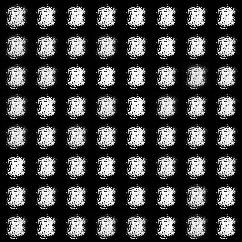



Epoch number: 2
[0/469]	Loss_D: 0.0300	Loss_G: 6.7753	D(x): 0.9846	D(G(z)): 0.0134 / 0.0043
[50/469]	Loss_D: 0.0268	Loss_G: 7.0336	D(x): 0.9822	D(G(z)): 0.0038 / 0.0022
[100/469]	Loss_D: 0.0084	Loss_G: 6.6882	D(x): 0.9944	D(G(z)): 0.0026 / 0.0019
[150/469]	Loss_D: 0.0442	Loss_G: 9.7127	D(x): 0.9820	D(G(z)): 0.0160 / 0.0081
[200/469]	Loss_D: 0.0299	Loss_G: 6.7295	D(x): 0.9869	D(G(z)): 0.0149 / 0.0072
[250/469]	Loss_D: 0.0241	Loss_G: 6.3258	D(x): 0.9899	D(G(z)): 0.0123 / 0.0031
[300/469]	Loss_D: 0.0311	Loss_G: 5.2500	D(x): 0.9883	D(G(z)): 0.0175 / 0.0074
[350/469]	Loss_D: 0.0178	Loss_G: 7.2752	D(x): 0.9874	D(G(z)): 0.0034 / 0.0016
[400/469]	Loss_D: 0.0155	Loss_G: 6.9121	D(x): 0.9941	D(G(z)): 0.0089 / 0.0030
[450/469]	Loss_D: 0.0164	Loss_G: 8.7716	D(x): 0.9931	D(G(z)): 0.0069 / 0.0029
[0/79]	Loss_D: 0.0222	Loss_G: 9.6327	D(x): 0.9879	D(G(z)): 0.0073 / 0.0073
[50/79]	Loss_D: 0.0151	Loss_G: 9.3539	D(x): 0.9891	D(G(z)): 0.0033 / 0.0033
Sample of generated images


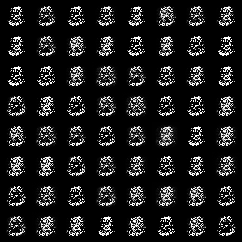



Epoch number: 3
[0/469]	Loss_D: 0.0142	Loss_G: 10.0097	D(x): 0.9906	D(G(z)): 0.0043 / 0.0022
[50/469]	Loss_D: 0.0230	Loss_G: 6.1899	D(x): 0.9920	D(G(z)): 0.0132 / 0.0071
[100/469]	Loss_D: 0.0383	Loss_G: 8.2789	D(x): 0.9793	D(G(z)): 0.0132 / 0.0051
[150/469]	Loss_D: 0.0159	Loss_G: 6.9032	D(x): 0.9933	D(G(z)): 0.0082 / 0.0037
[200/469]	Loss_D: 0.0285	Loss_G: 7.2493	D(x): 0.9867	D(G(z)): 0.0105 / 0.0054
[250/469]	Loss_D: 0.0328	Loss_G: 8.1794	D(x): 0.9856	D(G(z)): 0.0042 / 0.0018
[300/469]	Loss_D: 0.0096	Loss_G: 6.5122	D(x): 0.9986	D(G(z)): 0.0079 / 0.0046
[350/469]	Loss_D: 0.0548	Loss_G: 7.6737	D(x): 0.9912	D(G(z)): 0.0318 / 0.0091
[400/469]	Loss_D: 0.0335	Loss_G: 6.8711	D(x): 0.9836	D(G(z)): 0.0096 / 0.0070
[450/469]	Loss_D: 0.0226	Loss_G: 6.6750	D(x): 0.9896	D(G(z)): 0.0106 / 0.0060
[0/79]	Loss_D: 0.0496	Loss_G: 5.7134	D(x): 0.9753	D(G(z)): 0.0159 / 0.0159
[50/79]	Loss_D: 0.0448	Loss_G: 5.6520	D(x): 0.9884	D(G(z)): 0.0280 / 0.0280
Sample of generated images


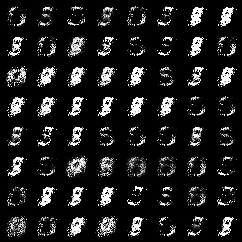



Epoch number: 4
[0/469]	Loss_D: 0.0613	Loss_G: 5.8340	D(x): 0.9742	D(G(z)): 0.0239 / 0.0145
[50/469]	Loss_D: 0.0280	Loss_G: 6.0611	D(x): 0.9935	D(G(z)): 0.0185 / 0.0123
[100/469]	Loss_D: 0.0255	Loss_G: 6.4038	D(x): 0.9972	D(G(z)): 0.0217 / 0.0103
[150/469]	Loss_D: 0.0275	Loss_G: 6.1687	D(x): 0.9863	D(G(z)): 0.0117 / 0.0075
[200/469]	Loss_D: 0.0312	Loss_G: 6.5676	D(x): 0.9878	D(G(z)): 0.0110 / 0.0064
[250/469]	Loss_D: 0.0312	Loss_G: 6.3492	D(x): 0.9845	D(G(z)): 0.0054 / 0.0041
[300/469]	Loss_D: 0.0227	Loss_G: 6.0249	D(x): 0.9903	D(G(z)): 0.0118 / 0.0080
[350/469]	Loss_D: 0.0314	Loss_G: 5.8678	D(x): 0.9883	D(G(z)): 0.0119 / 0.0086
[400/469]	Loss_D: 0.0336	Loss_G: 6.4642	D(x): 0.9882	D(G(z)): 0.0192 / 0.0129
[450/469]	Loss_D: 0.0395	Loss_G: 5.6410	D(x): 0.9823	D(G(z)): 0.0150 / 0.0098
[0/79]	Loss_D: 0.0729	Loss_G: 5.8126	D(x): 0.9761	D(G(z)): 0.0135 / 0.0135
[50/79]	Loss_D: 0.0220	Loss_G: 5.6624	D(x): 0.9934	D(G(z)): 0.0148 / 0.0148
Sample of generated images


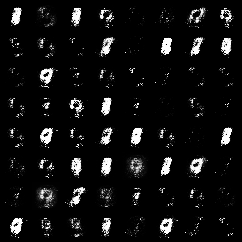



Epoch number: 5
[0/469]	Loss_D: 0.0321	Loss_G: 5.9766	D(x): 0.9857	D(G(z)): 0.0147 / 0.0101
[50/469]	Loss_D: 0.0261	Loss_G: 5.9227	D(x): 0.9963	D(G(z)): 0.0207 / 0.0099
[100/469]	Loss_D: 0.0118	Loss_G: 7.1234	D(x): 0.9925	D(G(z)): 0.0037 / 0.0029
[150/469]	Loss_D: 0.0237	Loss_G: 6.3501	D(x): 0.9893	D(G(z)): 0.0118 / 0.0066
[200/469]	Loss_D: 0.0515	Loss_G: 6.6199	D(x): 0.9839	D(G(z)): 0.0169 / 0.0078
[250/469]	Loss_D: 0.0458	Loss_G: 6.7822	D(x): 0.9729	D(G(z)): 0.0076 / 0.0029
[300/469]	Loss_D: 0.0948	Loss_G: 8.3011	D(x): 0.9542	D(G(z)): 0.0059 / 0.0033
[350/469]	Loss_D: 0.0839	Loss_G: 6.6673	D(x): 0.9799	D(G(z)): 0.0342 / 0.0164
[400/469]	Loss_D: 0.0560	Loss_G: 7.2145	D(x): 0.9760	D(G(z)): 0.0230 / 0.0086
[450/469]	Loss_D: 0.0319	Loss_G: 7.7531	D(x): 0.9836	D(G(z)): 0.0106 / 0.0037
[0/79]	Loss_D: 0.0845	Loss_G: 7.4109	D(x): 0.9683	D(G(z)): 0.0071 / 0.0071
[50/79]	Loss_D: 0.0462	Loss_G: 7.3220	D(x): 0.9791	D(G(z)): 0.0088 / 0.0088
Sample of generated images


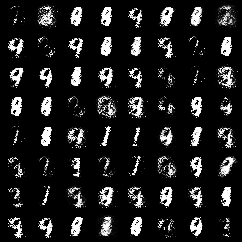



Epoch number: 6
[0/469]	Loss_D: 0.0377	Loss_G: 8.1539	D(x): 0.9848	D(G(z)): 0.0166 / 0.0074
[50/469]	Loss_D: 0.0603	Loss_G: 6.9145	D(x): 0.9755	D(G(z)): 0.0188 / 0.0077
[100/469]	Loss_D: 0.0746	Loss_G: 5.5920	D(x): 0.9726	D(G(z)): 0.0338 / 0.0185
[150/469]	Loss_D: 0.0770	Loss_G: 7.0971	D(x): 0.9743	D(G(z)): 0.0133 / 0.0048
[200/469]	Loss_D: 0.1201	Loss_G: 5.3563	D(x): 0.9550	D(G(z)): 0.0184 / 0.0236
[250/469]	Loss_D: 0.0473	Loss_G: 7.6834	D(x): 0.9711	D(G(z)): 0.0081 / 0.0049
[300/469]	Loss_D: 0.0600	Loss_G: 7.0915	D(x): 0.9789	D(G(z)): 0.0105 / 0.0074
[350/469]	Loss_D: 0.1049	Loss_G: 6.9163	D(x): 0.9543	D(G(z)): 0.0190 / 0.0162
[400/469]	Loss_D: 0.0361	Loss_G: 6.0020	D(x): 0.9853	D(G(z)): 0.0158 / 0.0155
[450/469]	Loss_D: 0.0579	Loss_G: 6.9826	D(x): 0.9822	D(G(z)): 0.0247 / 0.0152
[0/79]	Loss_D: 0.0383	Loss_G: 6.5149	D(x): 0.9786	D(G(z)): 0.0117 / 0.0117
[50/79]	Loss_D: 0.0912	Loss_G: 6.3383	D(x): 0.9525	D(G(z)): 0.0138 / 0.0138
Sample of generated images


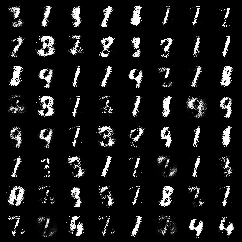



Epoch number: 7
[0/469]	Loss_D: 0.1015	Loss_G: 7.3591	D(x): 0.9617	D(G(z)): 0.0214 / 0.0075
[50/469]	Loss_D: 0.1278	Loss_G: 5.0910	D(x): 0.9773	D(G(z)): 0.0483 / 0.0283
[100/469]	Loss_D: 0.0493	Loss_G: 5.9240	D(x): 0.9781	D(G(z)): 0.0137 / 0.0107
[150/469]	Loss_D: 0.0524	Loss_G: 6.4812	D(x): 0.9899	D(G(z)): 0.0326 / 0.0165
[200/469]	Loss_D: 0.0554	Loss_G: 6.1032	D(x): 0.9883	D(G(z)): 0.0341 / 0.0149
[250/469]	Loss_D: 0.1034	Loss_G: 5.8331	D(x): 0.9619	D(G(z)): 0.0350 / 0.0175
[300/469]	Loss_D: 0.0690	Loss_G: 7.0165	D(x): 0.9711	D(G(z)): 0.0204 / 0.0137
[350/469]	Loss_D: 0.1662	Loss_G: 5.6600	D(x): 0.9627	D(G(z)): 0.0641 / 0.0430
[400/469]	Loss_D: 0.0917	Loss_G: 5.6658	D(x): 0.9765	D(G(z)): 0.0441 / 0.0235
[450/469]	Loss_D: 0.2013	Loss_G: 6.1740	D(x): 0.9257	D(G(z)): 0.0182 / 0.0185
[0/79]	Loss_D: 0.0902	Loss_G: 5.9490	D(x): 0.9629	D(G(z)): 0.0193 / 0.0193
[50/79]	Loss_D: 0.1230	Loss_G: 6.0657	D(x): 0.9386	D(G(z)): 0.0225 / 0.0225
Sample of generated images


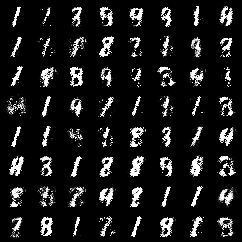



Epoch number: 8
[0/469]	Loss_D: 0.1158	Loss_G: 6.0353	D(x): 0.9667	D(G(z)): 0.0424 / 0.0299
[50/469]	Loss_D: 0.0290	Loss_G: 5.7326	D(x): 0.9952	D(G(z)): 0.0227 / 0.0126
[100/469]	Loss_D: 0.1338	Loss_G: 7.1290	D(x): 0.9642	D(G(z)): 0.0283 / 0.0135
[150/469]	Loss_D: 0.0675	Loss_G: 7.2396	D(x): 0.9699	D(G(z)): 0.0121 / 0.0055
[200/469]	Loss_D: 0.1290	Loss_G: 5.5461	D(x): 0.9866	D(G(z)): 0.0745 / 0.0315
[250/469]	Loss_D: 0.0976	Loss_G: 7.6435	D(x): 0.9774	D(G(z)): 0.0377 / 0.0152
[300/469]	Loss_D: 0.1041	Loss_G: 7.8542	D(x): 0.9580	D(G(z)): 0.0225 / 0.0114
[350/469]	Loss_D: 0.1054	Loss_G: 7.0313	D(x): 0.9557	D(G(z)): 0.0229 / 0.0112
[400/469]	Loss_D: 0.0488	Loss_G: 6.7520	D(x): 0.9887	D(G(z)): 0.0303 / 0.0133
[450/469]	Loss_D: 0.2043	Loss_G: 5.1001	D(x): 0.9558	D(G(z)): 0.0716 / 0.0645
[0/79]	Loss_D: 0.1561	Loss_G: 4.3376	D(x): 0.9834	D(G(z)): 0.0789 / 0.0789
[50/79]	Loss_D: 0.0947	Loss_G: 4.7691	D(x): 0.9776	D(G(z)): 0.0510 / 0.0510
Sample of generated images


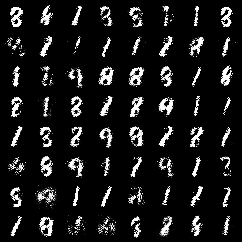



Epoch number: 9
[0/469]	Loss_D: 0.1214	Loss_G: 5.3166	D(x): 0.9767	D(G(z)): 0.0586 / 0.0323
[50/469]	Loss_D: 0.0621	Loss_G: 6.4154	D(x): 0.9765	D(G(z)): 0.0179 / 0.0126
[100/469]	Loss_D: 0.0893	Loss_G: 6.4681	D(x): 0.9653	D(G(z)): 0.0283 / 0.0138
[150/469]	Loss_D: 0.2341	Loss_G: 5.0684	D(x): 0.9871	D(G(z)): 0.1029 / 0.0727
[200/469]	Loss_D: 0.0750	Loss_G: 6.8845	D(x): 0.9755	D(G(z)): 0.0233 / 0.0120
[250/469]	Loss_D: 0.1463	Loss_G: 5.4644	D(x): 0.9612	D(G(z)): 0.0642 / 0.0484
[300/469]	Loss_D: 0.0684	Loss_G: 5.8283	D(x): 0.9778	D(G(z)): 0.0325 / 0.0265
[350/469]	Loss_D: 0.1704	Loss_G: 6.1445	D(x): 0.9341	D(G(z)): 0.0299 / 0.0178
[400/469]	Loss_D: 0.1347	Loss_G: 5.0024	D(x): 0.9711	D(G(z)): 0.0550 / 0.0439
[450/469]	Loss_D: 0.1437	Loss_G: 6.1348	D(x): 0.9372	D(G(z)): 0.0308 / 0.0215
[0/79]	Loss_D: 0.1285	Loss_G: 5.2793	D(x): 0.9564	D(G(z)): 0.0407 / 0.0407
[50/79]	Loss_D: 0.1605	Loss_G: 4.8815	D(x): 0.9409	D(G(z)): 0.0557 / 0.0557
Sample of generated images


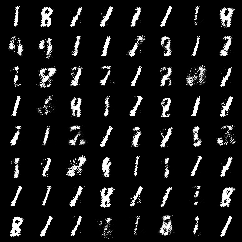



Epoch number: 10
[0/469]	Loss_D: 0.1028	Loss_G: 5.2189	D(x): 0.9523	D(G(z)): 0.0324 / 0.0304
[50/469]	Loss_D: 0.0961	Loss_G: 6.2189	D(x): 0.9624	D(G(z)): 0.0284 / 0.0241
[100/469]	Loss_D: 0.1318	Loss_G: 5.2602	D(x): 0.9750	D(G(z)): 0.0528 / 0.0403
[150/469]	Loss_D: 0.1226	Loss_G: 5.2653	D(x): 0.9565	D(G(z)): 0.0319 / 0.0361
[200/469]	Loss_D: 0.1219	Loss_G: 5.3514	D(x): 0.9474	D(G(z)): 0.0158 / 0.0180
[250/469]	Loss_D: 0.1750	Loss_G: 4.8893	D(x): 0.9304	D(G(z)): 0.0346 / 0.0402
[300/469]	Loss_D: 0.1698	Loss_G: 4.8983	D(x): 0.9667	D(G(z)): 0.0741 / 0.0582
[350/469]	Loss_D: 0.1914	Loss_G: 5.3280	D(x): 0.9500	D(G(z)): 0.0672 / 0.0405
[400/469]	Loss_D: 0.1381	Loss_G: 5.0649	D(x): 0.9414	D(G(z)): 0.0309 / 0.0287
[450/469]	Loss_D: 0.1067	Loss_G: 4.9915	D(x): 0.9716	D(G(z)): 0.0550 / 0.0342
[0/79]	Loss_D: 0.1605	Loss_G: 5.1374	D(x): 0.9501	D(G(z)): 0.0425 / 0.0425
[50/79]	Loss_D: 0.1727	Loss_G: 5.2581	D(x): 0.9441	D(G(z)): 0.0315 / 0.0315
Sample of generated images


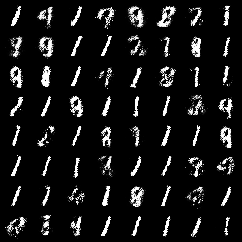



Epoch number: 11
[0/469]	Loss_D: 0.1548	Loss_G: 4.9339	D(x): 0.9380	D(G(z)): 0.0247 / 0.0289
[50/469]	Loss_D: 0.1482	Loss_G: 5.1121	D(x): 0.9328	D(G(z)): 0.0301 / 0.0267
[100/469]	Loss_D: 0.1429	Loss_G: 5.5686	D(x): 0.9379	D(G(z)): 0.0291 / 0.0208
[150/469]	Loss_D: 0.0905	Loss_G: 4.5742	D(x): 0.9729	D(G(z)): 0.0451 / 0.0459
[200/469]	Loss_D: 0.1847	Loss_G: 4.3420	D(x): 0.9372	D(G(z)): 0.0496 / 0.0488
[250/469]	Loss_D: 0.1868	Loss_G: 5.2607	D(x): 0.9465	D(G(z)): 0.0717 / 0.0482
[300/469]	Loss_D: 0.1188	Loss_G: 6.1049	D(x): 0.9512	D(G(z)): 0.0383 / 0.0204
[350/469]	Loss_D: 0.3120	Loss_G: 5.2821	D(x): 0.9007	D(G(z)): 0.0718 / 0.0426
[400/469]	Loss_D: 0.1856	Loss_G: 5.1524	D(x): 0.9391	D(G(z)): 0.0604 / 0.0314
[450/469]	Loss_D: 0.1954	Loss_G: 4.8071	D(x): 0.9453	D(G(z)): 0.0696 / 0.0503
[0/79]	Loss_D: 0.1183	Loss_G: 4.7909	D(x): 0.9662	D(G(z)): 0.0559 / 0.0559
[50/79]	Loss_D: 0.1636	Loss_G: 4.7913	D(x): 0.9391	D(G(z)): 0.0492 / 0.0492
Sample of generated images


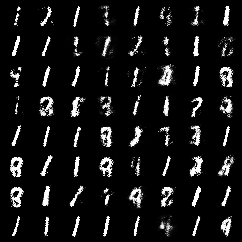



Epoch number: 12
[0/469]	Loss_D: 0.1257	Loss_G: 5.2947	D(x): 0.9483	D(G(z)): 0.0408 / 0.0244
[50/469]	Loss_D: 0.1672	Loss_G: 5.0187	D(x): 0.9453	D(G(z)): 0.0456 / 0.0248
[100/469]	Loss_D: 0.1517	Loss_G: 4.3213	D(x): 0.9450	D(G(z)): 0.0572 / 0.0405
[150/469]	Loss_D: 0.2212	Loss_G: 3.9199	D(x): 0.9165	D(G(z)): 0.0534 / 0.0606
[200/469]	Loss_D: 0.3262	Loss_G: 3.9732	D(x): 0.8799	D(G(z)): 0.0496 / 0.0480
[250/469]	Loss_D: 0.2546	Loss_G: 4.0948	D(x): 0.9369	D(G(z)): 0.0856 / 0.0611
[300/469]	Loss_D: 0.2643	Loss_G: 4.2685	D(x): 0.8963	D(G(z)): 0.0543 / 0.0524
[350/469]	Loss_D: 0.1687	Loss_G: 4.8863	D(x): 0.9401	D(G(z)): 0.0541 / 0.0406
[400/469]	Loss_D: 0.2925	Loss_G: 4.6948	D(x): 0.8995	D(G(z)): 0.0463 / 0.0400
[450/469]	Loss_D: 0.2431	Loss_G: 3.8341	D(x): 0.9183	D(G(z)): 0.0807 / 0.0623
[0/79]	Loss_D: 0.2805	Loss_G: 3.3152	D(x): 0.9241	D(G(z)): 0.1057 / 0.1057
[50/79]	Loss_D: 0.2220	Loss_G: 3.5228	D(x): 0.9444	D(G(z)): 0.0953 / 0.0953
Sample of generated images


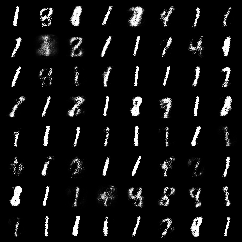



Epoch number: 13
[0/469]	Loss_D: 0.2769	Loss_G: 3.7044	D(x): 0.9372	D(G(z)): 0.1155 / 0.0984
[50/469]	Loss_D: 0.2797	Loss_G: 3.5737	D(x): 0.9366	D(G(z)): 0.1130 / 0.0923
[100/469]	Loss_D: 0.1106	Loss_G: 4.1206	D(x): 0.9605	D(G(z)): 0.0484 / 0.0486
[150/469]	Loss_D: 0.2669	Loss_G: 4.2178	D(x): 0.9102	D(G(z)): 0.0661 / 0.0511
[200/469]	Loss_D: 0.1915	Loss_G: 4.3725	D(x): 0.9323	D(G(z)): 0.0524 / 0.0490
[250/469]	Loss_D: 0.1604	Loss_G: 4.6103	D(x): 0.9511	D(G(z)): 0.0553 / 0.0337
[300/469]	Loss_D: 0.2292	Loss_G: 3.3875	D(x): 0.9448	D(G(z)): 0.1202 / 0.0768
[350/469]	Loss_D: 0.2413	Loss_G: 3.6583	D(x): 0.9450	D(G(z)): 0.1111 / 0.0717
[400/469]	Loss_D: 0.3359	Loss_G: 3.4478	D(x): 0.9193	D(G(z)): 0.1250 / 0.0966
[450/469]	Loss_D: 0.2797	Loss_G: 4.1136	D(x): 0.8900	D(G(z)): 0.0657 / 0.0523
[0/79]	Loss_D: 0.2873	Loss_G: 3.5550	D(x): 0.9071	D(G(z)): 0.0951 / 0.0951
[50/79]	Loss_D: 0.2852	Loss_G: 3.2828	D(x): 0.9326	D(G(z)): 0.1216 / 0.1216
Sample of generated images


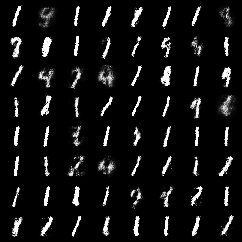



Epoch number: 14
[0/469]	Loss_D: 0.3087	Loss_G: 3.6970	D(x): 0.9226	D(G(z)): 0.1172 / 0.0869
[50/469]	Loss_D: 0.2324	Loss_G: 4.6881	D(x): 0.9090	D(G(z)): 0.0609 / 0.0406
[100/469]	Loss_D: 0.1889	Loss_G: 4.9394	D(x): 0.9574	D(G(z)): 0.0645 / 0.0388
[150/469]	Loss_D: 0.2851	Loss_G: 4.3189	D(x): 0.9359	D(G(z)): 0.1122 / 0.0518
[200/469]	Loss_D: 0.2932	Loss_G: 3.6170	D(x): 0.9153	D(G(z)): 0.0956 / 0.0811
[250/469]	Loss_D: 0.2487	Loss_G: 3.9947	D(x): 0.9306	D(G(z)): 0.0682 / 0.0728
[300/469]	Loss_D: 0.1627	Loss_G: 4.6050	D(x): 0.9469	D(G(z)): 0.0515 / 0.0319
[350/469]	Loss_D: 0.4152	Loss_G: 3.8832	D(x): 0.8895	D(G(z)): 0.1195 / 0.0925
[400/469]	Loss_D: 0.3426	Loss_G: 4.4171	D(x): 0.8876	D(G(z)): 0.0383 / 0.0431
[450/469]	Loss_D: 0.3936	Loss_G: 4.3323	D(x): 0.8958	D(G(z)): 0.0674 / 0.0463
[0/79]	Loss_D: 0.3441	Loss_G: 3.6920	D(x): 0.8845	D(G(z)): 0.0784 / 0.0784
[50/79]	Loss_D: 0.3834	Loss_G: 3.6195	D(x): 0.8769	D(G(z)): 0.0909 / 0.0909
Sample of generated images


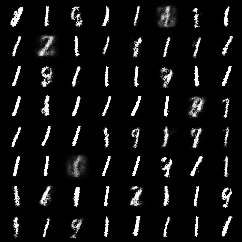



Epoch number: 15
[0/469]	Loss_D: 0.3230	Loss_G: 3.9977	D(x): 0.8941	D(G(z)): 0.0876 / 0.0706
[50/469]	Loss_D: 0.2303	Loss_G: 4.4574	D(x): 0.9229	D(G(z)): 0.0597 / 0.0400
[100/469]	Loss_D: 0.3508	Loss_G: 3.7460	D(x): 0.8824	D(G(z)): 0.0913 / 0.0737
[150/469]	Loss_D: 0.3184	Loss_G: 3.6641	D(x): 0.9036	D(G(z)): 0.0981 / 0.0792
[200/469]	Loss_D: 0.4739	Loss_G: 3.5645	D(x): 0.8760	D(G(z)): 0.1178 / 0.0904
[250/469]	Loss_D: 0.3353	Loss_G: 3.5286	D(x): 0.9060	D(G(z)): 0.0890 / 0.0802
[300/469]	Loss_D: 0.3513	Loss_G: 4.0798	D(x): 0.8885	D(G(z)): 0.0709 / 0.0553
[350/469]	Loss_D: 0.2144	Loss_G: 4.4559	D(x): 0.9323	D(G(z)): 0.0679 / 0.0379
[400/469]	Loss_D: 0.2795	Loss_G: 3.3200	D(x): 0.9351	D(G(z)): 0.1037 / 0.0950
[450/469]	Loss_D: 0.3146	Loss_G: 3.4327	D(x): 0.9107	D(G(z)): 0.1102 / 0.0975
[0/79]	Loss_D: 0.3456	Loss_G: 3.4255	D(x): 0.9186	D(G(z)): 0.0938 / 0.0938
[50/79]	Loss_D: 0.4540	Loss_G: 3.7411	D(x): 0.8696	D(G(z)): 0.0679 / 0.0679
Sample of generated images


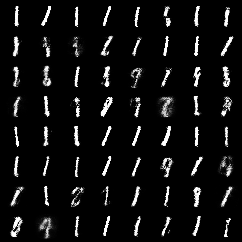



Epoch number: 16
[0/469]	Loss_D: 0.3529	Loss_G: 3.8067	D(x): 0.8955	D(G(z)): 0.0689 / 0.0674
[50/469]	Loss_D: 0.4462	Loss_G: 3.0317	D(x): 0.8541	D(G(z)): 0.1155 / 0.1152
[100/469]	Loss_D: 0.3046	Loss_G: 3.4508	D(x): 0.9081	D(G(z)): 0.0804 / 0.0744
[150/469]	Loss_D: 0.3995	Loss_G: 3.3388	D(x): 0.8809	D(G(z)): 0.0944 / 0.0819
[200/469]	Loss_D: 0.3195	Loss_G: 3.6515	D(x): 0.9171	D(G(z)): 0.0847 / 0.0813
[250/469]	Loss_D: 0.4126	Loss_G: 3.4786	D(x): 0.8837	D(G(z)): 0.0917 / 0.0877
[300/469]	Loss_D: 0.4300	Loss_G: 3.4194	D(x): 0.8871	D(G(z)): 0.1205 / 0.0815
[350/469]	Loss_D: 0.2553	Loss_G: 3.5859	D(x): 0.9358	D(G(z)): 0.1076 / 0.0800
[400/469]	Loss_D: 0.3317	Loss_G: 3.9342	D(x): 0.9057	D(G(z)): 0.0928 / 0.0658
[450/469]	Loss_D: 0.3448	Loss_G: 3.6412	D(x): 0.9036	D(G(z)): 0.1139 / 0.0793
[0/79]	Loss_D: 0.2705	Loss_G: 3.6457	D(x): 0.9302	D(G(z)): 0.0827 / 0.0827
[50/79]	Loss_D: 0.2825	Loss_G: 3.7743	D(x): 0.9216	D(G(z)): 0.0707 / 0.0707
Sample of generated images


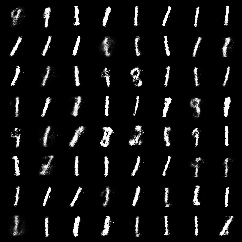



Epoch number: 17
[0/469]	Loss_D: 0.2625	Loss_G: 4.2259	D(x): 0.9123	D(G(z)): 0.0750 / 0.0567
[50/469]	Loss_D: 0.3892	Loss_G: 3.6812	D(x): 0.9260	D(G(z)): 0.1219 / 0.0914
[100/469]	Loss_D: 0.3900	Loss_G: 3.1899	D(x): 0.8924	D(G(z)): 0.1138 / 0.1150
[150/469]	Loss_D: 0.3433	Loss_G: 4.2058	D(x): 0.9147	D(G(z)): 0.0788 / 0.0544
[200/469]	Loss_D: 0.3660	Loss_G: 3.6264	D(x): 0.8877	D(G(z)): 0.1012 / 0.0838
[250/469]	Loss_D: 0.3663	Loss_G: 3.6376	D(x): 0.9400	D(G(z)): 0.1497 / 0.0905
[300/469]	Loss_D: 0.2926	Loss_G: 3.0791	D(x): 0.9349	D(G(z)): 0.1156 / 0.1083
[350/469]	Loss_D: 0.4822	Loss_G: 3.2079	D(x): 0.8726	D(G(z)): 0.1326 / 0.1199
[400/469]	Loss_D: 0.3508	Loss_G: 3.9129	D(x): 0.8931	D(G(z)): 0.0747 / 0.0653
[450/469]	Loss_D: 0.4555	Loss_G: 3.1507	D(x): 0.9114	D(G(z)): 0.1546 / 0.1213
[0/79]	Loss_D: 0.3799	Loss_G: 3.7969	D(x): 0.8876	D(G(z)): 0.0745 / 0.0745
[50/79]	Loss_D: 0.4410	Loss_G: 4.0977	D(x): 0.8745	D(G(z)): 0.0574 / 0.0574
Sample of generated images


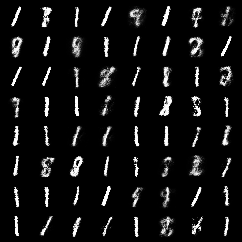



Epoch number: 18
[0/469]	Loss_D: 0.2601	Loss_G: 3.9039	D(x): 0.8979	D(G(z)): 0.0532 / 0.0535
[50/469]	Loss_D: 0.3073	Loss_G: 3.7360	D(x): 0.9051	D(G(z)): 0.1017 / 0.0715
[100/469]	Loss_D: 0.3259	Loss_G: 3.1595	D(x): 0.9405	D(G(z)): 0.1406 / 0.1156
[150/469]	Loss_D: 0.3625	Loss_G: 4.3540	D(x): 0.9155	D(G(z)): 0.1045 / 0.0713
[200/469]	Loss_D: 0.2477	Loss_G: 3.8055	D(x): 0.9365	D(G(z)): 0.0847 / 0.0686
[250/469]	Loss_D: 0.3374	Loss_G: 3.0023	D(x): 0.9290	D(G(z)): 0.1505 / 0.1149
[300/469]	Loss_D: 0.3340	Loss_G: 2.9282	D(x): 0.9287	D(G(z)): 0.1576 / 0.1293
[350/469]	Loss_D: 0.2827	Loss_G: 3.5077	D(x): 0.9246	D(G(z)): 0.1055 / 0.0790
[400/469]	Loss_D: 0.3686	Loss_G: 3.7108	D(x): 0.9012	D(G(z)): 0.1069 / 0.0709
[450/469]	Loss_D: 0.4709	Loss_G: 3.4160	D(x): 0.8493	D(G(z)): 0.0990 / 0.0861
[0/79]	Loss_D: 0.4322	Loss_G: 3.3309	D(x): 0.8826	D(G(z)): 0.1049 / 0.1049
[50/79]	Loss_D: 0.4358	Loss_G: 3.4625	D(x): 0.8686	D(G(z)): 0.0892 / 0.0892
Sample of generated images


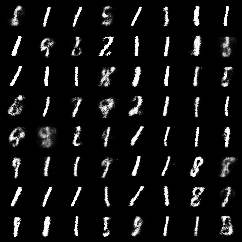



Epoch number: 19
[0/469]	Loss_D: 0.3109	Loss_G: 3.3422	D(x): 0.9204	D(G(z)): 0.1014 / 0.0955
[50/469]	Loss_D: 0.3674	Loss_G: 3.3423	D(x): 0.9121	D(G(z)): 0.1240 / 0.0908
[100/469]	Loss_D: 0.4406	Loss_G: 3.3372	D(x): 0.8729	D(G(z)): 0.1206 / 0.1003
[150/469]	Loss_D: 0.3949	Loss_G: 3.5332	D(x): 0.8645	D(G(z)): 0.0916 / 0.0820
[200/469]	Loss_D: 0.4572	Loss_G: 3.3146	D(x): 0.8373	D(G(z)): 0.0731 / 0.0785
[250/469]	Loss_D: 0.4865	Loss_G: 3.2198	D(x): 0.8820	D(G(z)): 0.1617 / 0.1102
[300/469]	Loss_D: 0.4388	Loss_G: 3.6444	D(x): 0.8765	D(G(z)): 0.1100 / 0.0822
[350/469]	Loss_D: 0.4072	Loss_G: 3.5094	D(x): 0.8713	D(G(z)): 0.0802 / 0.0793
[400/469]	Loss_D: 0.4006	Loss_G: 2.6403	D(x): 0.9121	D(G(z)): 0.1725 / 0.1442
[450/469]	Loss_D: 0.4967	Loss_G: 3.9069	D(x): 0.8851	D(G(z)): 0.0916 / 0.0810
[0/79]	Loss_D: 0.3949	Loss_G: 3.3386	D(x): 0.8699	D(G(z)): 0.0834 / 0.0834
[50/79]	Loss_D: 0.5509	Loss_G: 3.0082	D(x): 0.8692	D(G(z)): 0.1507 / 0.1507
Sample of generated images


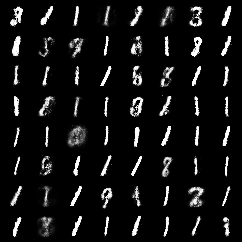



Epoch number: 20
[0/469]	Loss_D: 0.3258	Loss_G: 3.7092	D(x): 0.9145	D(G(z)): 0.1120 / 0.0812
[50/469]	Loss_D: 0.3707	Loss_G: 2.8069	D(x): 0.9060	D(G(z)): 0.1622 / 0.1375
[100/469]	Loss_D: 0.3440	Loss_G: 2.9454	D(x): 0.9084	D(G(z)): 0.1347 / 0.1123
[150/469]	Loss_D: 0.4097	Loss_G: 3.1545	D(x): 0.8696	D(G(z)): 0.1072 / 0.0908
[200/469]	Loss_D: 0.3761	Loss_G: 3.2413	D(x): 0.8971	D(G(z)): 0.1216 / 0.1125
[250/469]	Loss_D: 0.4387	Loss_G: 3.0577	D(x): 0.8876	D(G(z)): 0.1423 / 0.1121
[300/469]	Loss_D: 0.5352	Loss_G: 3.2595	D(x): 0.8683	D(G(z)): 0.1352 / 0.1041
[350/469]	Loss_D: 0.3446	Loss_G: 3.1313	D(x): 0.8890	D(G(z)): 0.0937 / 0.0963
[400/469]	Loss_D: 0.4473	Loss_G: 2.9448	D(x): 0.8817	D(G(z)): 0.1174 / 0.1189
[450/469]	Loss_D: 0.5026	Loss_G: 3.0877	D(x): 0.8696	D(G(z)): 0.1294 / 0.1125
[0/79]	Loss_D: 0.3173	Loss_G: 3.1334	D(x): 0.9206	D(G(z)): 0.0960 / 0.0960
[50/79]	Loss_D: 0.3281	Loss_G: 3.2589	D(x): 0.8934	D(G(z)): 0.0885 / 0.0885
Sample of generated images


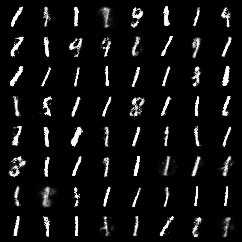



Epoch number: 21
[0/469]	Loss_D: 0.3228	Loss_G: 3.1722	D(x): 0.9179	D(G(z)): 0.1062 / 0.0987
[50/469]	Loss_D: 0.3916	Loss_G: 3.1310	D(x): 0.8957	D(G(z)): 0.1335 / 0.1144
[100/469]	Loss_D: 0.3738	Loss_G: 2.9485	D(x): 0.8985	D(G(z)): 0.1425 / 0.1297
[150/469]	Loss_D: 0.4788	Loss_G: 3.6713	D(x): 0.8334	D(G(z)): 0.0789 / 0.0650
[200/469]	Loss_D: 0.3838	Loss_G: 2.8753	D(x): 0.9149	D(G(z)): 0.1420 / 0.1134
[250/469]	Loss_D: 0.5650	Loss_G: 3.2167	D(x): 0.8448	D(G(z)): 0.1215 / 0.1003
[300/469]	Loss_D: 0.4694	Loss_G: 3.3120	D(x): 0.8595	D(G(z)): 0.1118 / 0.0953
[350/469]	Loss_D: 0.4217	Loss_G: 3.0900	D(x): 0.9150	D(G(z)): 0.1434 / 0.1322
[400/469]	Loss_D: 0.3502	Loss_G: 2.9594	D(x): 0.8953	D(G(z)): 0.1111 / 0.1155
[450/469]	Loss_D: 0.3753	Loss_G: 3.3031	D(x): 0.8982	D(G(z)): 0.1081 / 0.0954
[0/79]	Loss_D: 0.3492	Loss_G: 3.2543	D(x): 0.8933	D(G(z)): 0.0837 / 0.0837
[50/79]	Loss_D: 0.3720	Loss_G: 3.4772	D(x): 0.8657	D(G(z)): 0.0625 / 0.0625
Sample of generated images


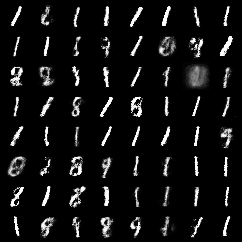



Epoch number: 22
[0/469]	Loss_D: 0.2964	Loss_G: 3.4383	D(x): 0.9119	D(G(z)): 0.0842 / 0.0785
[50/469]	Loss_D: 0.3665	Loss_G: 3.2032	D(x): 0.8979	D(G(z)): 0.1132 / 0.0981
[100/469]	Loss_D: 0.4033	Loss_G: 2.7688	D(x): 0.8997	D(G(z)): 0.1363 / 0.1305
[150/469]	Loss_D: 0.3322	Loss_G: 3.0384	D(x): 0.9141	D(G(z)): 0.1226 / 0.0914
[200/469]	Loss_D: 0.4912	Loss_G: 3.2671	D(x): 0.8811	D(G(z)): 0.1295 / 0.1143
[250/469]	Loss_D: 0.4308	Loss_G: 3.4095	D(x): 0.8527	D(G(z)): 0.0872 / 0.0882
[300/469]	Loss_D: 0.4222	Loss_G: 2.6541	D(x): 0.8953	D(G(z)): 0.1716 / 0.1485
[350/469]	Loss_D: 0.3846	Loss_G: 3.1730	D(x): 0.8899	D(G(z)): 0.1170 / 0.0922
[400/469]	Loss_D: 0.6445	Loss_G: 2.7753	D(x): 0.8587	D(G(z)): 0.1838 / 0.1645
[450/469]	Loss_D: 0.4173	Loss_G: 3.0838	D(x): 0.8708	D(G(z)): 0.1144 / 0.1023
[0/79]	Loss_D: 0.7330	Loss_G: 2.4599	D(x): 0.8444	D(G(z)): 0.1835 / 0.1835
[50/79]	Loss_D: 0.5944	Loss_G: 2.3660	D(x): 0.8862	D(G(z)): 0.1905 / 0.1905
Sample of generated images


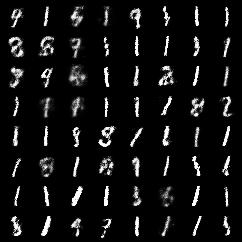



Epoch number: 23
[0/469]	Loss_D: 0.5854	Loss_G: 2.6095	D(x): 0.8875	D(G(z)): 0.2174 / 0.1747
[50/469]	Loss_D: 0.3705	Loss_G: 3.0629	D(x): 0.9025	D(G(z)): 0.1397 / 0.1209
[100/469]	Loss_D: 0.3714	Loss_G: 2.8887	D(x): 0.8793	D(G(z)): 0.1276 / 0.1177
[150/469]	Loss_D: 0.4866	Loss_G: 2.7708	D(x): 0.8814	D(G(z)): 0.1398 / 0.1449
[200/469]	Loss_D: 0.3068	Loss_G: 2.9256	D(x): 0.9200	D(G(z)): 0.1273 / 0.1059
[250/469]	Loss_D: 0.4191	Loss_G: 2.9165	D(x): 0.8634	D(G(z)): 0.1210 / 0.1116
[300/469]	Loss_D: 0.4854	Loss_G: 3.3377	D(x): 0.8495	D(G(z)): 0.1210 / 0.0999
[350/469]	Loss_D: 0.4868	Loss_G: 3.6126	D(x): 0.8466	D(G(z)): 0.0913 / 0.0642
[400/469]	Loss_D: 0.6405	Loss_G: 2.7707	D(x): 0.8621	D(G(z)): 0.1823 / 0.1714
[450/469]	Loss_D: 0.5295	Loss_G: 2.9899	D(x): 0.8574	D(G(z)): 0.1468 / 0.1222
[0/79]	Loss_D: 0.3596	Loss_G: 2.8525	D(x): 0.8993	D(G(z)): 0.1456 / 0.1456
[50/79]	Loss_D: 0.3540	Loss_G: 2.9492	D(x): 0.9346	D(G(z)): 0.1391 / 0.1391
Sample of generated images


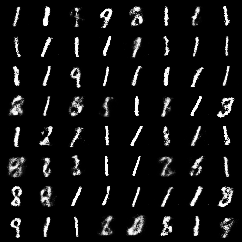



Epoch number: 24
[0/469]	Loss_D: 0.3025	Loss_G: 3.0354	D(x): 0.9485	D(G(z)): 0.1465 / 0.1176
[50/469]	Loss_D: 0.3919	Loss_G: 3.0652	D(x): 0.8986	D(G(z)): 0.1262 / 0.1055
[100/469]	Loss_D: 0.3461	Loss_G: 3.4155	D(x): 0.9126	D(G(z)): 0.1331 / 0.0932
[150/469]	Loss_D: 0.6046	Loss_G: 2.2931	D(x): 0.8948	D(G(z)): 0.2429 / 0.1975
[200/469]	Loss_D: 0.4063	Loss_G: 3.7373	D(x): 0.8597	D(G(z)): 0.0888 / 0.0750
[250/469]	Loss_D: 0.4724	Loss_G: 2.9895	D(x): 0.8245	D(G(z)): 0.1160 / 0.1072
[300/469]	Loss_D: 0.4254	Loss_G: 3.1578	D(x): 0.8785	D(G(z)): 0.1185 / 0.0953
[350/469]	Loss_D: 0.4261	Loss_G: 3.1899	D(x): 0.8722	D(G(z)): 0.1301 / 0.1123
[400/469]	Loss_D: 0.5011	Loss_G: 3.2337	D(x): 0.8489	D(G(z)): 0.0940 / 0.0870
[450/469]	Loss_D: 0.5434	Loss_G: 3.2104	D(x): 0.8345	D(G(z)): 0.1210 / 0.1123
[0/79]	Loss_D: 0.5781	Loss_G: 2.7855	D(x): 0.8471	D(G(z)): 0.1362 / 0.1362
[50/79]	Loss_D: 0.5524	Loss_G: 2.4649	D(x): 0.8987	D(G(z)): 0.1851 / 0.1851
Sample of generated images


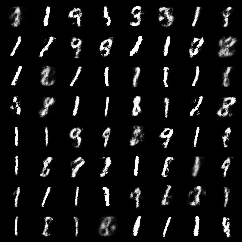



Epoch number: 25
[0/469]	Loss_D: 0.6191	Loss_G: 2.8677	D(x): 0.8660	D(G(z)): 0.1580 / 0.1464
[50/469]	Loss_D: 0.3330	Loss_G: 3.2481	D(x): 0.8967	D(G(z)): 0.1016 / 0.0898
[100/469]	Loss_D: 0.5005	Loss_G: 3.5623	D(x): 0.8408	D(G(z)): 0.0673 / 0.0622
[150/469]	Loss_D: 0.3408	Loss_G: 3.2889	D(x): 0.9069	D(G(z)): 0.1115 / 0.0959
[200/469]	Loss_D: 0.6903	Loss_G: 2.5963	D(x): 0.8391	D(G(z)): 0.1794 / 0.1652
[250/469]	Loss_D: 0.5013	Loss_G: 2.4911	D(x): 0.8763	D(G(z)): 0.1812 / 0.1580
[300/469]	Loss_D: 0.5166	Loss_G: 3.0837	D(x): 0.8319	D(G(z)): 0.1031 / 0.0998
[350/469]	Loss_D: 0.4369	Loss_G: 3.2671	D(x): 0.8533	D(G(z)): 0.1089 / 0.1065
[400/469]	Loss_D: 0.3534	Loss_G: 3.2021	D(x): 0.8957	D(G(z)): 0.1126 / 0.1009
[450/469]	Loss_D: 0.5315	Loss_G: 2.5770	D(x): 0.8396	D(G(z)): 0.1450 / 0.1400
[0/79]	Loss_D: 0.3502	Loss_G: 2.9931	D(x): 0.9065	D(G(z)): 0.1245 / 0.1245
[50/79]	Loss_D: 0.3758	Loss_G: 2.5868	D(x): 0.8863	D(G(z)): 0.1406 / 0.1406
Sample of generated images


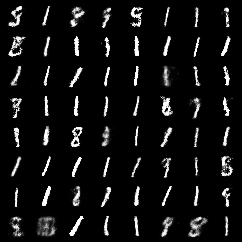



Epoch number: 26
[0/469]	Loss_D: 0.5675	Loss_G: 2.5599	D(x): 0.8522	D(G(z)): 0.1726 / 0.1532
[50/469]	Loss_D: 0.4582	Loss_G: 3.1663	D(x): 0.8367	D(G(z)): 0.0888 / 0.0910
[100/469]	Loss_D: 0.3795	Loss_G: 3.3241	D(x): 0.8919	D(G(z)): 0.1054 / 0.0928
[150/469]	Loss_D: 0.3896	Loss_G: 2.8245	D(x): 0.8737	D(G(z)): 0.1045 / 0.1094
[200/469]	Loss_D: 0.4924	Loss_G: 3.1728	D(x): 0.8295	D(G(z)): 0.0979 / 0.0989
[250/469]	Loss_D: 0.4490	Loss_G: 2.9371	D(x): 0.8466	D(G(z)): 0.1109 / 0.1095
[300/469]	Loss_D: 0.3909	Loss_G: 3.3902	D(x): 0.8717	D(G(z)): 0.0934 / 0.0758
[350/469]	Loss_D: 0.5112	Loss_G: 3.1901	D(x): 0.8193	D(G(z)): 0.0973 / 0.0927
[400/469]	Loss_D: 0.3966	Loss_G: 2.8957	D(x): 0.8838	D(G(z)): 0.1395 / 0.1183
[450/469]	Loss_D: 0.4717	Loss_G: 3.2936	D(x): 0.8791	D(G(z)): 0.1354 / 0.1063
[0/79]	Loss_D: 0.7121	Loss_G: 2.2272	D(x): 0.8597	D(G(z)): 0.2419 / 0.2419
[50/79]	Loss_D: 0.5189	Loss_G: 2.2206	D(x): 0.9201	D(G(z)): 0.2153 / 0.2153
Sample of generated images


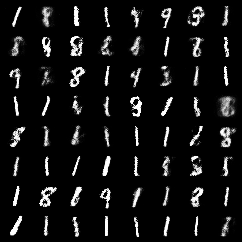



Epoch number: 27
[0/469]	Loss_D: 0.5373	Loss_G: 2.3935	D(x): 0.8987	D(G(z)): 0.2177 / 0.1878
[50/469]	Loss_D: 0.4891	Loss_G: 2.8045	D(x): 0.8540	D(G(z)): 0.1370 / 0.1403
[100/469]	Loss_D: 0.6281	Loss_G: 3.0482	D(x): 0.8505	D(G(z)): 0.1863 / 0.1346
[150/469]	Loss_D: 0.4050	Loss_G: 3.7484	D(x): 0.8735	D(G(z)): 0.0924 / 0.0691
[200/469]	Loss_D: 0.4512	Loss_G: 2.9175	D(x): 0.8556	D(G(z)): 0.1301 / 0.1229
[250/469]	Loss_D: 0.5035	Loss_G: 3.2196	D(x): 0.8333	D(G(z)): 0.1055 / 0.1040
[300/469]	Loss_D: 0.6375	Loss_G: 3.0406	D(x): 0.8333	D(G(z)): 0.1320 / 0.1261
[350/469]	Loss_D: 0.4311	Loss_G: 2.9202	D(x): 0.8705	D(G(z)): 0.1173 / 0.1152
[400/469]	Loss_D: 0.5514	Loss_G: 2.8841	D(x): 0.8233	D(G(z)): 0.1532 / 0.1344
[450/469]	Loss_D: 0.4283	Loss_G: 3.1440	D(x): 0.8819	D(G(z)): 0.1238 / 0.1122
[0/79]	Loss_D: 0.7541	Loss_G: 2.5443	D(x): 0.8835	D(G(z)): 0.2149 / 0.2149
[50/79]	Loss_D: 0.3800	Loss_G: 2.7860	D(x): 0.9034	D(G(z)): 0.1375 / 0.1375
Sample of generated images


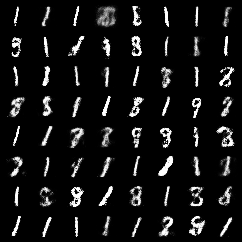



Epoch number: 28
[0/469]	Loss_D: 0.4469	Loss_G: 3.0510	D(x): 0.8761	D(G(z)): 0.1361 / 0.1122
[50/469]	Loss_D: 0.4603	Loss_G: 3.2854	D(x): 0.8464	D(G(z)): 0.1204 / 0.0879
[100/469]	Loss_D: 0.3546	Loss_G: 3.2637	D(x): 0.8737	D(G(z)): 0.1127 / 0.0906
[150/469]	Loss_D: 0.5800	Loss_G: 2.8984	D(x): 0.8335	D(G(z)): 0.1424 / 0.1250
[200/469]	Loss_D: 0.5447	Loss_G: 2.4661	D(x): 0.8889	D(G(z)): 0.1880 / 0.1797
[250/469]	Loss_D: 0.4544	Loss_G: 2.7682	D(x): 0.8641	D(G(z)): 0.1388 / 0.1286
[300/469]	Loss_D: 0.4236	Loss_G: 3.3214	D(x): 0.8727	D(G(z)): 0.0968 / 0.0796
[350/469]	Loss_D: 0.3115	Loss_G: 3.2470	D(x): 0.9170	D(G(z)): 0.1228 / 0.0886
[400/469]	Loss_D: 0.3996	Loss_G: 3.0421	D(x): 0.8959	D(G(z)): 0.1433 / 0.1099
[450/469]	Loss_D: 0.4289	Loss_G: 3.2255	D(x): 0.8701	D(G(z)): 0.1305 / 0.0994
[0/79]	Loss_D: 0.5052	Loss_G: 2.4675	D(x): 0.8726	D(G(z)): 0.1787 / 0.1787
[50/79]	Loss_D: 0.5437	Loss_G: 2.4911	D(x): 0.8434	D(G(z)): 0.1576 / 0.1576
Sample of generated images


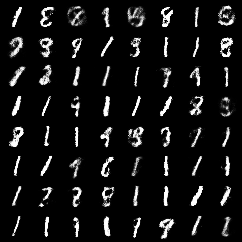



Epoch number: 29
[0/469]	Loss_D: 0.5814	Loss_G: 2.6971	D(x): 0.8367	D(G(z)): 0.1454 / 0.1434
[50/469]	Loss_D: 0.5492	Loss_G: 2.5009	D(x): 0.8779	D(G(z)): 0.1971 / 0.1632
[100/469]	Loss_D: 0.4594	Loss_G: 2.5368	D(x): 0.8682	D(G(z)): 0.1571 / 0.1596
[150/469]	Loss_D: 0.4042	Loss_G: 3.1986	D(x): 0.8647	D(G(z)): 0.1073 / 0.1069
[200/469]	Loss_D: 0.4169	Loss_G: 2.5579	D(x): 0.8950	D(G(z)): 0.1759 / 0.1581
[250/469]	Loss_D: 0.4965	Loss_G: 3.1051	D(x): 0.8556	D(G(z)): 0.1301 / 0.1081
[300/469]	Loss_D: 0.5520	Loss_G: 2.6406	D(x): 0.8693	D(G(z)): 0.1688 / 0.1442
[350/469]	Loss_D: 0.5228	Loss_G: 2.9356	D(x): 0.8428	D(G(z)): 0.1337 / 0.1206
[400/469]	Loss_D: 0.4492	Loss_G: 2.5833	D(x): 0.8824	D(G(z)): 0.1727 / 0.1510
[450/469]	Loss_D: 0.4261	Loss_G: 3.0398	D(x): 0.8651	D(G(z)): 0.1293 / 0.1210
[0/79]	Loss_D: 0.5690	Loss_G: 2.9510	D(x): 0.8349	D(G(z)): 0.1334 / 0.1334
[50/79]	Loss_D: 0.6341	Loss_G: 3.0279	D(x): 0.8200	D(G(z)): 0.1418 / 0.1418
Sample of generated images


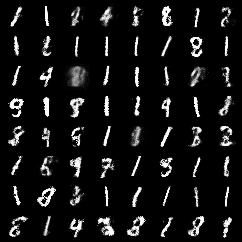



Epoch number: 30
[0/469]	Loss_D: 0.3570	Loss_G: 3.3354	D(x): 0.8675	D(G(z)): 0.0945 / 0.0862
[50/469]	Loss_D: 0.6496	Loss_G: 2.8462	D(x): 0.8133	D(G(z)): 0.1550 / 0.1557
[100/469]	Loss_D: 0.4675	Loss_G: 2.8450	D(x): 0.8559	D(G(z)): 0.1310 / 0.1254
[150/469]	Loss_D: 0.5063	Loss_G: 3.0796	D(x): 0.8207	D(G(z)): 0.1035 / 0.1103
[200/469]	Loss_D: 0.5206	Loss_G: 2.5999	D(x): 0.8512	D(G(z)): 0.1633 / 0.1603
[250/469]	Loss_D: 0.6343	Loss_G: 3.1185	D(x): 0.8389	D(G(z)): 0.1389 / 0.1385
[300/469]	Loss_D: 0.6539	Loss_G: 2.7221	D(x): 0.8290	D(G(z)): 0.1836 / 0.1566
[350/469]	Loss_D: 0.4626	Loss_G: 3.2360	D(x): 0.8599	D(G(z)): 0.1414 / 0.1051
[400/469]	Loss_D: 0.3684	Loss_G: 3.3427	D(x): 0.8854	D(G(z)): 0.1242 / 0.0997
[450/469]	Loss_D: 0.5672	Loss_G: 2.4736	D(x): 0.8720	D(G(z)): 0.1813 / 0.1655
[0/79]	Loss_D: 0.6604	Loss_G: 3.3272	D(x): 0.8189	D(G(z)): 0.1206 / 0.1206
[50/79]	Loss_D: 0.5793	Loss_G: 3.5014	D(x): 0.8046	D(G(z)): 0.0913 / 0.0913
Sample of generated images


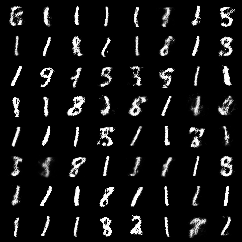



Epoch number: 31
[0/469]	Loss_D: 0.4120	Loss_G: 3.6842	D(x): 0.8573	D(G(z)): 0.0839 / 0.0834
[50/469]	Loss_D: 0.4824	Loss_G: 3.0933	D(x): 0.8499	D(G(z)): 0.1312 / 0.1091
[100/469]	Loss_D: 0.5202	Loss_G: 3.2312	D(x): 0.8643	D(G(z)): 0.1453 / 0.1119
[150/469]	Loss_D: 0.4933	Loss_G: 3.3902	D(x): 0.8857	D(G(z)): 0.1410 / 0.1176
[200/469]	Loss_D: 0.4321	Loss_G: 2.6941	D(x): 0.9116	D(G(z)): 0.1855 / 0.1470
[250/469]	Loss_D: 0.5319	Loss_G: 2.6869	D(x): 0.8425	D(G(z)): 0.1476 / 0.1508
[300/469]	Loss_D: 0.4596	Loss_G: 3.5101	D(x): 0.8438	D(G(z)): 0.1041 / 0.0916
[350/469]	Loss_D: 0.4934	Loss_G: 2.7537	D(x): 0.8924	D(G(z)): 0.2041 / 0.1527
[400/469]	Loss_D: 0.5380	Loss_G: 2.8033	D(x): 0.8542	D(G(z)): 0.1650 / 0.1514
[450/469]	Loss_D: 0.2931	Loss_G: 3.2476	D(x): 0.9190	D(G(z)): 0.1216 / 0.1004
[0/79]	Loss_D: 0.6695	Loss_G: 2.8237	D(x): 0.8121	D(G(z)): 0.1427 / 0.1427
[50/79]	Loss_D: 0.6107	Loss_G: 2.9645	D(x): 0.8424	D(G(z)): 0.1545 / 0.1545
Sample of generated images


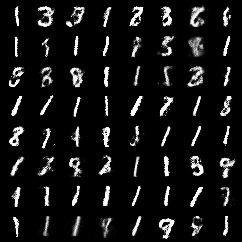



Epoch number: 32
[0/469]	Loss_D: 0.4657	Loss_G: 3.0648	D(x): 0.8556	D(G(z)): 0.1260 / 0.1100
[50/469]	Loss_D: 0.6051	Loss_G: 2.7937	D(x): 0.8493	D(G(z)): 0.1543 / 0.1545
[100/469]	Loss_D: 0.4143	Loss_G: 2.9103	D(x): 0.8858	D(G(z)): 0.1502 / 0.1233
[150/469]	Loss_D: 0.5509	Loss_G: 2.6054	D(x): 0.8295	D(G(z)): 0.1524 / 0.1418
[200/469]	Loss_D: 0.4827	Loss_G: 2.8114	D(x): 0.8483	D(G(z)): 0.1433 / 0.1340
[250/469]	Loss_D: 0.4452	Loss_G: 2.8291	D(x): 0.8527	D(G(z)): 0.1295 / 0.1295
[300/469]	Loss_D: 0.6976	Loss_G: 2.0664	D(x): 0.8528	D(G(z)): 0.2351 / 0.2346
[350/469]	Loss_D: 0.4695	Loss_G: 2.8730	D(x): 0.8922	D(G(z)): 0.1548 / 0.1269
[400/469]	Loss_D: 0.3653	Loss_G: 3.1502	D(x): 0.8796	D(G(z)): 0.1059 / 0.0988
[450/469]	Loss_D: 0.5339	Loss_G: 2.5837	D(x): 0.8241	D(G(z)): 0.1457 / 0.1405
[0/79]	Loss_D: 0.4283	Loss_G: 2.9533	D(x): 0.8458	D(G(z)): 0.1138 / 0.1138
[50/79]	Loss_D: 0.5091	Loss_G: 2.8470	D(x): 0.8483	D(G(z)): 0.1393 / 0.1393
Sample of generated images


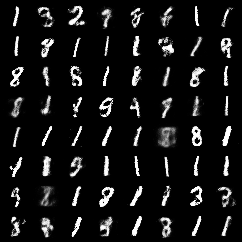



Epoch number: 33
[0/469]	Loss_D: 0.5069	Loss_G: 2.7493	D(x): 0.8442	D(G(z)): 0.1352 / 0.1372
[50/469]	Loss_D: 0.5206	Loss_G: 2.5527	D(x): 0.8749	D(G(z)): 0.1903 / 0.1763
[100/469]	Loss_D: 0.4412	Loss_G: 3.0989	D(x): 0.8571	D(G(z)): 0.1169 / 0.1040
[150/469]	Loss_D: 0.5273	Loss_G: 2.5740	D(x): 0.8481	D(G(z)): 0.1556 / 0.1402
[200/469]	Loss_D: 0.5560	Loss_G: 2.7178	D(x): 0.8249	D(G(z)): 0.1366 / 0.1341
[250/469]	Loss_D: 0.5050	Loss_G: 3.0204	D(x): 0.8502	D(G(z)): 0.1411 / 0.1205
[300/469]	Loss_D: 0.6307	Loss_G: 2.7050	D(x): 0.8232	D(G(z)): 0.1464 / 0.1292
[350/469]	Loss_D: 0.5462	Loss_G: 2.5800	D(x): 0.8542	D(G(z)): 0.1648 / 0.1588
[400/469]	Loss_D: 0.6388	Loss_G: 2.3796	D(x): 0.8069	D(G(z)): 0.1548 / 0.1655
[450/469]	Loss_D: 0.4945	Loss_G: 2.7232	D(x): 0.8456	D(G(z)): 0.1454 / 0.1392
[0/79]	Loss_D: 0.7392	Loss_G: 2.6534	D(x): 0.8487	D(G(z)): 0.1611 / 0.1611
[50/79]	Loss_D: 0.6431	Loss_G: 2.6387	D(x): 0.8213	D(G(z)): 0.1668 / 0.1668
Sample of generated images


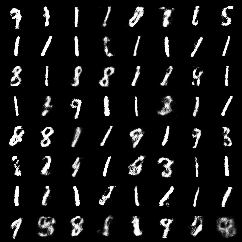



Epoch number: 34
[0/469]	Loss_D: 0.5399	Loss_G: 2.7971	D(x): 0.8439	D(G(z)): 0.1308 / 0.1333
[50/469]	Loss_D: 0.4197	Loss_G: 3.0278	D(x): 0.8626	D(G(z)): 0.1321 / 0.1163
[100/469]	Loss_D: 0.6447	Loss_G: 2.5423	D(x): 0.8220	D(G(z)): 0.1603 / 0.1447
[150/469]	Loss_D: 0.4979	Loss_G: 2.8817	D(x): 0.8893	D(G(z)): 0.1516 / 0.1253
[200/469]	Loss_D: 0.4635	Loss_G: 2.7663	D(x): 0.8460	D(G(z)): 0.1107 / 0.1114
[250/469]	Loss_D: 0.5603	Loss_G: 2.9725	D(x): 0.8246	D(G(z)): 0.1236 / 0.1269
[300/469]	Loss_D: 0.5127	Loss_G: 2.7306	D(x): 0.8823	D(G(z)): 0.1871 / 0.1562
[350/469]	Loss_D: 0.4255	Loss_G: 2.5734	D(x): 0.8873	D(G(z)): 0.1712 / 0.1702
[400/469]	Loss_D: 0.5676	Loss_G: 2.7853	D(x): 0.7993	D(G(z)): 0.1279 / 0.1166
[450/469]	Loss_D: 0.3874	Loss_G: 2.7452	D(x): 0.8979	D(G(z)): 0.1517 / 0.1223
[0/79]	Loss_D: 0.4599	Loss_G: 2.9152	D(x): 0.8603	D(G(z)): 0.1243 / 0.1243
[50/79]	Loss_D: 0.5160	Loss_G: 2.7600	D(x): 0.8484	D(G(z)): 0.1272 / 0.1272
Sample of generated images


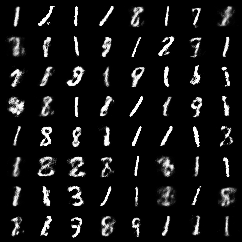



Epoch number: 35
[0/469]	Loss_D: 0.5700	Loss_G: 2.7038	D(x): 0.8590	D(G(z)): 0.1528 / 0.1496
[50/469]	Loss_D: 0.4469	Loss_G: 2.5585	D(x): 0.8643	D(G(z)): 0.1594 / 0.1450
[100/469]	Loss_D: 0.5214	Loss_G: 2.5807	D(x): 0.8251	D(G(z)): 0.1382 / 0.1318
[150/469]	Loss_D: 0.3896	Loss_G: 2.9056	D(x): 0.8804	D(G(z)): 0.1272 / 0.1130
[200/469]	Loss_D: 0.4550	Loss_G: 2.3241	D(x): 0.8772	D(G(z)): 0.1815 / 0.1686
[250/469]	Loss_D: 0.4571	Loss_G: 2.8333	D(x): 0.8848	D(G(z)): 0.1581 / 0.1248
[300/469]	Loss_D: 0.4852	Loss_G: 2.9178	D(x): 0.8873	D(G(z)): 0.1492 / 0.1346
[350/469]	Loss_D: 0.5204	Loss_G: 2.5800	D(x): 0.8628	D(G(z)): 0.1576 / 0.1503
[400/469]	Loss_D: 0.6774	Loss_G: 2.2816	D(x): 0.8276	D(G(z)): 0.2244 / 0.1990
[450/469]	Loss_D: 0.4659	Loss_G: 2.9259	D(x): 0.8631	D(G(z)): 0.1314 / 0.1088
[0/79]	Loss_D: 0.5817	Loss_G: 2.3008	D(x): 0.8271	D(G(z)): 0.1865 / 0.1865
[50/79]	Loss_D: 0.4955	Loss_G: 2.3988	D(x): 0.8709	D(G(z)): 0.1663 / 0.1663
Sample of generated images


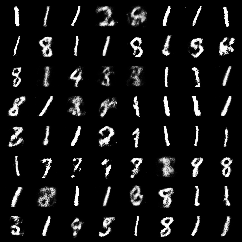



Epoch number: 36
[0/469]	Loss_D: 0.4117	Loss_G: 2.4754	D(x): 0.8928	D(G(z)): 0.1660 / 0.1493
[50/469]	Loss_D: 0.4595	Loss_G: 3.0957	D(x): 0.8638	D(G(z)): 0.1466 / 0.1226
[100/469]	Loss_D: 0.5989	Loss_G: 2.7141	D(x): 0.8135	D(G(z)): 0.1526 / 0.1376
[150/469]	Loss_D: 0.4587	Loss_G: 2.7191	D(x): 0.8612	D(G(z)): 0.1510 / 0.1345
[200/469]	Loss_D: 0.4396	Loss_G: 2.4235	D(x): 0.8845	D(G(z)): 0.1765 / 0.1642
[250/469]	Loss_D: 0.5804	Loss_G: 2.4123	D(x): 0.8850	D(G(z)): 0.2154 / 0.1788
[300/469]	Loss_D: 0.4962	Loss_G: 2.6974	D(x): 0.8390	D(G(z)): 0.1414 / 0.1274
[350/469]	Loss_D: 0.4341	Loss_G: 2.8131	D(x): 0.8494	D(G(z)): 0.1270 / 0.1227
[400/469]	Loss_D: 0.4910	Loss_G: 2.9525	D(x): 0.8275	D(G(z)): 0.1048 / 0.1099
[450/469]	Loss_D: 0.6321	Loss_G: 2.6847	D(x): 0.8069	D(G(z)): 0.1445 / 0.1335
[0/79]	Loss_D: 0.5346	Loss_G: 2.5809	D(x): 0.8454	D(G(z)): 0.1540 / 0.1540
[50/79]	Loss_D: 0.5392	Loss_G: 2.7828	D(x): 0.8282	D(G(z)): 0.1339 / 0.1339
Sample of generated images


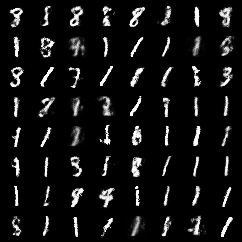



Epoch number: 37
[0/469]	Loss_D: 0.4875	Loss_G: 2.6112	D(x): 0.8544	D(G(z)): 0.1539 / 0.1406
[50/469]	Loss_D: 0.5314	Loss_G: 2.6584	D(x): 0.8314	D(G(z)): 0.1427 / 0.1397
[100/469]	Loss_D: 0.5934	Loss_G: 2.7964	D(x): 0.8318	D(G(z)): 0.1518 / 0.1279
[150/469]	Loss_D: 0.4980	Loss_G: 2.8144	D(x): 0.8222	D(G(z)): 0.1295 / 0.1256
[200/469]	Loss_D: 0.6013	Loss_G: 2.8190	D(x): 0.8565	D(G(z)): 0.1844 / 0.1480
[250/469]	Loss_D: 0.3500	Loss_G: 2.8990	D(x): 0.9088	D(G(z)): 0.1390 / 0.1231
[300/469]	Loss_D: 0.5834	Loss_G: 2.7944	D(x): 0.8556	D(G(z)): 0.1607 / 0.1491
[350/469]	Loss_D: 0.4703	Loss_G: 2.5552	D(x): 0.8970	D(G(z)): 0.2046 / 0.1737
[400/469]	Loss_D: 0.5408	Loss_G: 2.8175	D(x): 0.8124	D(G(z)): 0.1348 / 0.1211
[450/469]	Loss_D: 0.5637	Loss_G: 2.5591	D(x): 0.8652	D(G(z)): 0.1995 / 0.1819
[0/79]	Loss_D: 0.5724	Loss_G: 3.0036	D(x): 0.8005	D(G(z)): 0.1033 / 0.1033
[50/79]	Loss_D: 0.6531	Loss_G: 2.9289	D(x): 0.7833	D(G(z)): 0.1108 / 0.1108
Sample of generated images


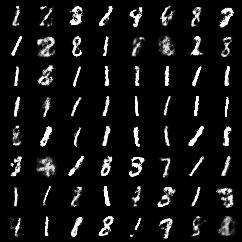



Epoch number: 38
[0/469]	Loss_D: 0.5142	Loss_G: 3.0053	D(x): 0.8281	D(G(z)): 0.1199 / 0.1061
[50/469]	Loss_D: 0.5809	Loss_G: 2.7164	D(x): 0.8657	D(G(z)): 0.1769 / 0.1544
[100/469]	Loss_D: 0.4998	Loss_G: 2.2593	D(x): 0.8531	D(G(z)): 0.1877 / 0.1772
[150/469]	Loss_D: 0.3777	Loss_G: 2.9673	D(x): 0.8840	D(G(z)): 0.1203 / 0.1134
[200/469]	Loss_D: 0.6274	Loss_G: 2.6282	D(x): 0.8071	D(G(z)): 0.1590 / 0.1392
[250/469]	Loss_D: 0.5751	Loss_G: 2.5705	D(x): 0.8191	D(G(z)): 0.1620 / 0.1542
[300/469]	Loss_D: 0.3844	Loss_G: 3.0916	D(x): 0.8545	D(G(z)): 0.1021 / 0.0982
[350/469]	Loss_D: 0.3855	Loss_G: 2.8623	D(x): 0.8804	D(G(z)): 0.1306 / 0.1290
[400/469]	Loss_D: 0.4796	Loss_G: 2.8590	D(x): 0.8683	D(G(z)): 0.1448 / 0.1318
[450/469]	Loss_D: 0.4385	Loss_G: 2.8063	D(x): 0.8843	D(G(z)): 0.1520 / 0.1295
[0/79]	Loss_D: 0.4574	Loss_G: 2.6913	D(x): 0.8737	D(G(z)): 0.1420 / 0.1420
[50/79]	Loss_D: 0.5582	Loss_G: 2.7037	D(x): 0.8367	D(G(z)): 0.1593 / 0.1593
Sample of generated images


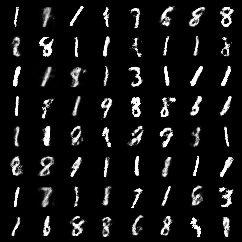



Epoch number: 39
[0/469]	Loss_D: 0.4052	Loss_G: 2.8306	D(x): 0.8951	D(G(z)): 0.1531 / 0.1393
[50/469]	Loss_D: 0.4953	Loss_G: 2.6757	D(x): 0.8313	D(G(z)): 0.1478 / 0.1346
[100/469]	Loss_D: 0.7576	Loss_G: 2.7284	D(x): 0.7638	D(G(z)): 0.1517 / 0.1455
[150/469]	Loss_D: 0.5616	Loss_G: 2.6447	D(x): 0.8222	D(G(z)): 0.1568 / 0.1433
[200/469]	Loss_D: 0.3831	Loss_G: 2.7694	D(x): 0.8875	D(G(z)): 0.1576 / 0.1307
[250/469]	Loss_D: 0.4706	Loss_G: 2.7786	D(x): 0.8810	D(G(z)): 0.1661 / 0.1313
[300/469]	Loss_D: 0.5479	Loss_G: 2.7309	D(x): 0.8162	D(G(z)): 0.1447 / 0.1364
[350/469]	Loss_D: 0.4968	Loss_G: 2.5886	D(x): 0.8807	D(G(z)): 0.1762 / 0.1549
[400/469]	Loss_D: 0.5240	Loss_G: 2.5937	D(x): 0.8544	D(G(z)): 0.1567 / 0.1595
[450/469]	Loss_D: 0.6470	Loss_G: 2.4539	D(x): 0.8291	D(G(z)): 0.1909 / 0.1740
[0/79]	Loss_D: 0.5107	Loss_G: 2.8936	D(x): 0.8238	D(G(z)): 0.1208 / 0.1208
[50/79]	Loss_D: 0.5723	Loss_G: 3.1259	D(x): 0.8210	D(G(z)): 0.1191 / 0.1191
Sample of generated images


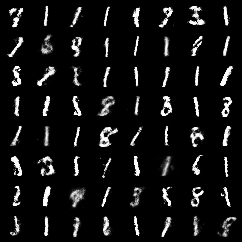



Epoch number: 40
[0/469]	Loss_D: 0.4507	Loss_G: 2.8962	D(x): 0.8503	D(G(z)): 0.1269 / 0.1216
[50/469]	Loss_D: 0.6108	Loss_G: 2.5683	D(x): 0.8288	D(G(z)): 0.1825 / 0.1630
[100/469]	Loss_D: 0.5835	Loss_G: 2.6541	D(x): 0.8359	D(G(z)): 0.1792 / 0.1589
[150/469]	Loss_D: 0.5052	Loss_G: 2.8518	D(x): 0.8490	D(G(z)): 0.1436 / 0.1285
[200/469]	Loss_D: 0.6636	Loss_G: 2.8519	D(x): 0.7881	D(G(z)): 0.1437 / 0.1320
[250/469]	Loss_D: 0.5848	Loss_G: 2.3283	D(x): 0.8581	D(G(z)): 0.2075 / 0.1930
[300/469]	Loss_D: 0.5328	Loss_G: 2.6277	D(x): 0.8355	D(G(z)): 0.1565 / 0.1433
[350/469]	Loss_D: 0.4185	Loss_G: 2.8399	D(x): 0.8735	D(G(z)): 0.1224 / 0.1205
[400/469]	Loss_D: 0.5365	Loss_G: 2.5538	D(x): 0.8474	D(G(z)): 0.1685 / 0.1582
[450/469]	Loss_D: 0.4868	Loss_G: 2.5225	D(x): 0.8670	D(G(z)): 0.1721 / 0.1539
[0/79]	Loss_D: 0.5817	Loss_G: 2.1660	D(x): 0.8320	D(G(z)): 0.1975 / 0.1975
[50/79]	Loss_D: 0.8064	Loss_G: 2.2273	D(x): 0.8110	D(G(z)): 0.2096 / 0.2096
Sample of generated images


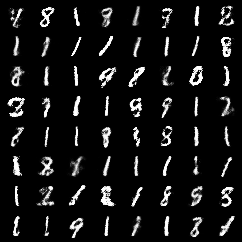



Epoch number: 41
[0/469]	Loss_D: 0.6198	Loss_G: 2.2833	D(x): 0.8333	D(G(z)): 0.2302 / 0.1824
[50/469]	Loss_D: 0.7337	Loss_G: 2.5480	D(x): 0.7605	D(G(z)): 0.1529 / 0.1643
[100/469]	Loss_D: 0.5394	Loss_G: 2.9422	D(x): 0.8060	D(G(z)): 0.1250 / 0.1020
[150/469]	Loss_D: 0.5212	Loss_G: 2.5724	D(x): 0.8560	D(G(z)): 0.1892 / 0.1527
[200/469]	Loss_D: 0.6974	Loss_G: 2.9616	D(x): 0.7827	D(G(z)): 0.1276 / 0.1288
[250/469]	Loss_D: 0.7439	Loss_G: 2.4389	D(x): 0.8279	D(G(z)): 0.2310 / 0.2048
[300/469]	Loss_D: 0.5036	Loss_G: 3.1280	D(x): 0.8330	D(G(z)): 0.1306 / 0.1088
[350/469]	Loss_D: 0.4010	Loss_G: 3.0563	D(x): 0.8682	D(G(z)): 0.1151 / 0.0952
[400/469]	Loss_D: 0.4823	Loss_G: 2.9586	D(x): 0.8383	D(G(z)): 0.1404 / 0.1189
[450/469]	Loss_D: 0.5018	Loss_G: 2.8181	D(x): 0.8394	D(G(z)): 0.1313 / 0.1232
[0/79]	Loss_D: 0.4798	Loss_G: 2.8207	D(x): 0.8527	D(G(z)): 0.1369 / 0.1369
[50/79]	Loss_D: 0.6103	Loss_G: 2.4676	D(x): 0.8188	D(G(z)): 0.1737 / 0.1737
Sample of generated images


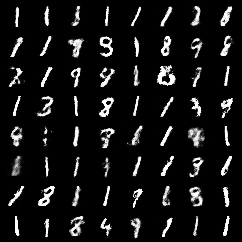



Epoch number: 42
[0/469]	Loss_D: 0.5793	Loss_G: 2.7070	D(x): 0.8253	D(G(z)): 0.1504 / 0.1464
[50/469]	Loss_D: 0.3737	Loss_G: 2.7619	D(x): 0.8923	D(G(z)): 0.1412 / 0.1283
[100/469]	Loss_D: 0.6072	Loss_G: 2.4708	D(x): 0.8110	D(G(z)): 0.1579 / 0.1684
[150/469]	Loss_D: 0.5001	Loss_G: 3.0852	D(x): 0.8211	D(G(z)): 0.1151 / 0.1092
[200/469]	Loss_D: 0.4832	Loss_G: 2.4104	D(x): 0.8531	D(G(z)): 0.1673 / 0.1621
[250/469]	Loss_D: 0.5442	Loss_G: 2.5321	D(x): 0.8289	D(G(z)): 0.1557 / 0.1497
[300/469]	Loss_D: 0.6666	Loss_G: 2.7253	D(x): 0.7824	D(G(z)): 0.1581 / 0.1452
[350/469]	Loss_D: 0.5148	Loss_G: 2.5699	D(x): 0.8561	D(G(z)): 0.1879 / 0.1492
[400/469]	Loss_D: 0.5573	Loss_G: 2.3614	D(x): 0.8665	D(G(z)): 0.2206 / 0.1884
[450/469]	Loss_D: 0.7022	Loss_G: 2.7111	D(x): 0.8192	D(G(z)): 0.1739 / 0.1632
[0/79]	Loss_D: 0.5674	Loss_G: 2.7327	D(x): 0.8288	D(G(z)): 0.1434 / 0.1434
[50/79]	Loss_D: 0.5333	Loss_G: 2.6585	D(x): 0.8364	D(G(z)): 0.1541 / 0.1541
Sample of generated images


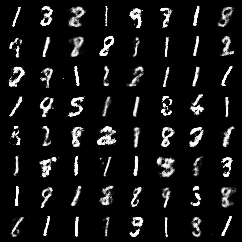



Epoch number: 43
[0/469]	Loss_D: 0.5133	Loss_G: 2.5251	D(x): 0.8472	D(G(z)): 0.1716 / 0.1588
[50/469]	Loss_D: 0.5095	Loss_G: 2.4872	D(x): 0.8495	D(G(z)): 0.1799 / 0.1558
[100/469]	Loss_D: 0.6679	Loss_G: 2.5421	D(x): 0.8015	D(G(z)): 0.1864 / 0.1744
[150/469]	Loss_D: 0.6675	Loss_G: 2.4860	D(x): 0.7863	D(G(z)): 0.1600 / 0.1580
[200/469]	Loss_D: 0.5039	Loss_G: 2.4810	D(x): 0.8668	D(G(z)): 0.1725 / 0.1547
[250/469]	Loss_D: 0.5457	Loss_G: 2.3698	D(x): 0.8704	D(G(z)): 0.2111 / 0.1939
[300/469]	Loss_D: 0.4873	Loss_G: 2.8893	D(x): 0.8379	D(G(z)): 0.1353 / 0.1250
[350/469]	Loss_D: 0.6163	Loss_G: 2.4531	D(x): 0.8299	D(G(z)): 0.2016 / 0.1817
[400/469]	Loss_D: 0.5112	Loss_G: 2.3891	D(x): 0.8311	D(G(z)): 0.1663 / 0.1565
[450/469]	Loss_D: 0.7088	Loss_G: 2.9361	D(x): 0.7704	D(G(z)): 0.1150 / 0.1192
[0/79]	Loss_D: 0.6333	Loss_G: 2.5280	D(x): 0.8144	D(G(z)): 0.1742 / 0.1742
[50/79]	Loss_D: 0.7115	Loss_G: 2.3053	D(x): 0.8106	D(G(z)): 0.1987 / 0.1987
Sample of generated images


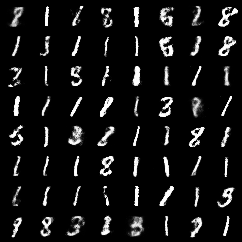



Epoch number: 44
[0/469]	Loss_D: 0.5904	Loss_G: 2.7430	D(x): 0.8293	D(G(z)): 0.1828 / 0.1482
[50/469]	Loss_D: 0.5406	Loss_G: 2.7824	D(x): 0.8283	D(G(z)): 0.1426 / 0.1255
[100/469]	Loss_D: 0.4046	Loss_G: 2.7198	D(x): 0.8669	D(G(z)): 0.1508 / 0.1340
[150/469]	Loss_D: 0.5089	Loss_G: 2.1893	D(x): 0.8691	D(G(z)): 0.2185 / 0.1938
[200/469]	Loss_D: 0.5779	Loss_G: 2.2462	D(x): 0.8444	D(G(z)): 0.2112 / 0.1962
[250/469]	Loss_D: 0.5291	Loss_G: 2.5847	D(x): 0.8633	D(G(z)): 0.1752 / 0.1603
[300/469]	Loss_D: 0.5637	Loss_G: 2.5763	D(x): 0.8579	D(G(z)): 0.1796 / 0.1695
[350/469]	Loss_D: 0.4997	Loss_G: 2.4873	D(x): 0.8523	D(G(z)): 0.1661 / 0.1577
[400/469]	Loss_D: 0.3980	Loss_G: 2.8666	D(x): 0.8828	D(G(z)): 0.1492 / 0.1293
[450/469]	Loss_D: 0.5249	Loss_G: 2.9285	D(x): 0.8284	D(G(z)): 0.1294 / 0.1249
[0/79]	Loss_D: 0.3714	Loss_G: 2.4456	D(x): 0.8935	D(G(z)): 0.1601 / 0.1601
[50/79]	Loss_D: 0.5120	Loss_G: 2.5069	D(x): 0.8517	D(G(z)): 0.1736 / 0.1736
Sample of generated images


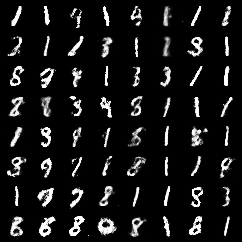



Epoch number: 45
[0/469]	Loss_D: 0.5249	Loss_G: 2.8321	D(x): 0.8759	D(G(z)): 0.1834 / 0.1513
[50/469]	Loss_D: 0.5606	Loss_G: 2.7963	D(x): 0.8086	D(G(z)): 0.1319 / 0.1291
[100/469]	Loss_D: 0.6297	Loss_G: 2.4567	D(x): 0.8069	D(G(z)): 0.1823 / 0.1652
[150/469]	Loss_D: 0.4624	Loss_G: 2.5467	D(x): 0.8855	D(G(z)): 0.1749 / 0.1616
[200/469]	Loss_D: 0.4192	Loss_G: 2.6523	D(x): 0.8922	D(G(z)): 0.1559 / 0.1394
[250/469]	Loss_D: 0.4621	Loss_G: 2.5807	D(x): 0.8731	D(G(z)): 0.1593 / 0.1549
[300/469]	Loss_D: 0.4313	Loss_G: 2.7211	D(x): 0.8612	D(G(z)): 0.1456 / 0.1288
[350/469]	Loss_D: 0.5405	Loss_G: 2.5248	D(x): 0.8277	D(G(z)): 0.1541 / 0.1515
[400/469]	Loss_D: 0.4576	Loss_G: 2.7874	D(x): 0.8716	D(G(z)): 0.1503 / 0.1507
[450/469]	Loss_D: 0.7154	Loss_G: 2.1093	D(x): 0.8299	D(G(z)): 0.2428 / 0.2333
[0/79]	Loss_D: 0.4552	Loss_G: 2.4236	D(x): 0.8772	D(G(z)): 0.1816 / 0.1816
[50/79]	Loss_D: 0.5860	Loss_G: 2.5628	D(x): 0.8112	D(G(z)): 0.1545 / 0.1545
Sample of generated images


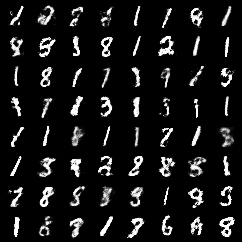



Epoch number: 46
[0/469]	Loss_D: 0.4738	Loss_G: 2.6127	D(x): 0.8422	D(G(z)): 0.1446 / 0.1396
[50/469]	Loss_D: 0.6004	Loss_G: 2.4270	D(x): 0.8372	D(G(z)): 0.2064 / 0.1869
[100/469]	Loss_D: 0.5469	Loss_G: 2.4857	D(x): 0.8532	D(G(z)): 0.1735 / 0.1606
[150/469]	Loss_D: 0.5565	Loss_G: 2.5448	D(x): 0.8365	D(G(z)): 0.1823 / 0.1675
[200/469]	Loss_D: 0.5074	Loss_G: 2.7615	D(x): 0.8146	D(G(z)): 0.1472 / 0.1291
[250/469]	Loss_D: 0.5722	Loss_G: 2.6604	D(x): 0.8385	D(G(z)): 0.1970 / 0.1717
[300/469]	Loss_D: 0.5911	Loss_G: 2.5367	D(x): 0.8205	D(G(z)): 0.1908 / 0.1858
[350/469]	Loss_D: 0.5461	Loss_G: 2.6890	D(x): 0.8622	D(G(z)): 0.1834 / 0.1462
[400/469]	Loss_D: 0.4981	Loss_G: 2.6544	D(x): 0.8435	D(G(z)): 0.1476 / 0.1385
[450/469]	Loss_D: 0.6173	Loss_G: 2.3594	D(x): 0.8674	D(G(z)): 0.2366 / 0.2101
[0/79]	Loss_D: 0.5997	Loss_G: 2.4401	D(x): 0.8340	D(G(z)): 0.1713 / 0.1713
[50/79]	Loss_D: 0.6065	Loss_G: 2.2722	D(x): 0.8290	D(G(z)): 0.2038 / 0.2038
Sample of generated images


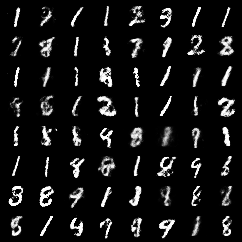



Epoch number: 47
[0/469]	Loss_D: 0.4543	Loss_G: 2.3715	D(x): 0.8615	D(G(z)): 0.1788 / 0.1671
[50/469]	Loss_D: 0.5056	Loss_G: 2.6196	D(x): 0.8488	D(G(z)): 0.1897 / 0.1499
[100/469]	Loss_D: 0.4897	Loss_G: 2.3846	D(x): 0.8714	D(G(z)): 0.2014 / 0.1808
[150/469]	Loss_D: 0.6420	Loss_G: 2.7262	D(x): 0.8081	D(G(z)): 0.1715 / 0.1587
[200/469]	Loss_D: 0.6256	Loss_G: 2.7936	D(x): 0.8127	D(G(z)): 0.1631 / 0.1444
[250/469]	Loss_D: 0.5406	Loss_G: 3.1554	D(x): 0.8195	D(G(z)): 0.1117 / 0.1030
[300/469]	Loss_D: 0.5902	Loss_G: 2.7099	D(x): 0.8135	D(G(z)): 0.1662 / 0.1568
[350/469]	Loss_D: 0.6553	Loss_G: 2.1511	D(x): 0.8369	D(G(z)): 0.2231 / 0.2195
[400/469]	Loss_D: 0.5936	Loss_G: 2.6765	D(x): 0.8128	D(G(z)): 0.1510 / 0.1393
[450/469]	Loss_D: 0.4883	Loss_G: 2.5919	D(x): 0.8376	D(G(z)): 0.1486 / 0.1471
[0/79]	Loss_D: 0.6503	Loss_G: 2.2958	D(x): 0.8299	D(G(z)): 0.2257 / 0.2257
[50/79]	Loss_D: 0.5569	Loss_G: 2.3109	D(x): 0.8464	D(G(z)): 0.2096 / 0.2096
Sample of generated images


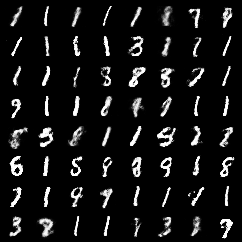



Epoch number: 48
[0/469]	Loss_D: 0.5291	Loss_G: 2.6756	D(x): 0.8594	D(G(z)): 0.1830 / 0.1575
[50/469]	Loss_D: 0.5269	Loss_G: 2.3430	D(x): 0.8682	D(G(z)): 0.2154 / 0.1749
[100/469]	Loss_D: 0.6216	Loss_G: 2.2722	D(x): 0.8313	D(G(z)): 0.2135 / 0.1926
[150/469]	Loss_D: 0.6483	Loss_G: 2.6173	D(x): 0.8034	D(G(z)): 0.1760 / 0.1619
[200/469]	Loss_D: 0.5527	Loss_G: 2.4644	D(x): 0.8486	D(G(z)): 0.1946 / 0.1759
[250/469]	Loss_D: 0.4353	Loss_G: 2.6617	D(x): 0.8845	D(G(z)): 0.1639 / 0.1495
[300/469]	Loss_D: 0.5921	Loss_G: 2.8776	D(x): 0.8004	D(G(z)): 0.1464 / 0.1369
[350/469]	Loss_D: 0.4238	Loss_G: 2.9473	D(x): 0.8708	D(G(z)): 0.1359 / 0.1123
[400/469]	Loss_D: 0.4999	Loss_G: 2.4758	D(x): 0.8647	D(G(z)): 0.1790 / 0.1603
[450/469]	Loss_D: 0.6222	Loss_G: 2.9645	D(x): 0.8271	D(G(z)): 0.1481 / 0.1313
[0/79]	Loss_D: 0.6017	Loss_G: 2.4261	D(x): 0.8056	D(G(z)): 0.1754 / 0.1754
[50/79]	Loss_D: 0.5980	Loss_G: 2.4143	D(x): 0.8151	D(G(z)): 0.1656 / 0.1656
Sample of generated images


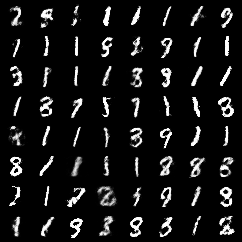



Epoch number: 49
[0/469]	Loss_D: 0.5162	Loss_G: 2.4283	D(x): 0.8362	D(G(z)): 0.1710 / 0.1700
[50/469]	Loss_D: 0.4523	Loss_G: 2.4717	D(x): 0.8741	D(G(z)): 0.1828 / 0.1573
[100/469]	Loss_D: 0.4533	Loss_G: 2.9043	D(x): 0.8438	D(G(z)): 0.1191 / 0.1201
[150/469]	Loss_D: 0.4952	Loss_G: 2.6429	D(x): 0.8834	D(G(z)): 0.1822 / 0.1528
[200/469]	Loss_D: 0.4850	Loss_G: 2.7801	D(x): 0.8363	D(G(z)): 0.1458 / 0.1409
[250/469]	Loss_D: 0.4435	Loss_G: 2.9150	D(x): 0.8516	D(G(z)): 0.1372 / 0.1302
[300/469]	Loss_D: 0.5849	Loss_G: 2.6889	D(x): 0.8400	D(G(z)): 0.1602 / 0.1577
[350/469]	Loss_D: 0.4065	Loss_G: 2.9346	D(x): 0.8475	D(G(z)): 0.1101 / 0.1116
[400/469]	Loss_D: 0.4181	Loss_G: 2.6835	D(x): 0.8720	D(G(z)): 0.1442 / 0.1284
[450/469]	Loss_D: 0.5063	Loss_G: 2.9205	D(x): 0.8315	D(G(z)): 0.1340 / 0.1278
[0/79]	Loss_D: 0.5089	Loss_G: 2.7665	D(x): 0.8179	D(G(z)): 0.1354 / 0.1354
[50/79]	Loss_D: 0.5830	Loss_G: 2.8588	D(x): 0.7968	D(G(z)): 0.1321 / 0.1321
Sample of generated images


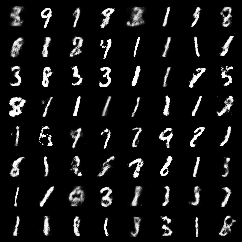



Epoch number: 50
[0/469]	Loss_D: 0.4955	Loss_G: 2.8750	D(x): 0.8376	D(G(z)): 0.1415 / 0.1192
[50/469]	Loss_D: 0.6310	Loss_G: 2.4689	D(x): 0.8272	D(G(z)): 0.2137 / 0.1840
[100/469]	Loss_D: 0.4792	Loss_G: 2.8432	D(x): 0.8228	D(G(z)): 0.1223 / 0.1138
[150/469]	Loss_D: 0.4952	Loss_G: 2.7324	D(x): 0.8265	D(G(z)): 0.1483 / 0.1379
[200/469]	Loss_D: 0.4732	Loss_G: 3.0047	D(x): 0.8292	D(G(z)): 0.1175 / 0.1054
[250/469]	Loss_D: 0.4825	Loss_G: 2.8606	D(x): 0.8381	D(G(z)): 0.1354 / 0.1302
[300/469]	Loss_D: 0.5679	Loss_G: 2.7578	D(x): 0.8259	D(G(z)): 0.1446 / 0.1346
[350/469]	Loss_D: 0.5089	Loss_G: 2.6699	D(x): 0.8672	D(G(z)): 0.1713 / 0.1540
[400/469]	Loss_D: 0.6355	Loss_G: 2.6288	D(x): 0.7992	D(G(z)): 0.1535 / 0.1503
[450/469]	Loss_D: 0.4145	Loss_G: 2.7853	D(x): 0.8886	D(G(z)): 0.1671 / 0.1548
[0/79]	Loss_D: 0.6608	Loss_G: 2.3696	D(x): 0.7718	D(G(z)): 0.1779 / 0.1779
[50/79]	Loss_D: 0.6693	Loss_G: 2.3720	D(x): 0.8024	D(G(z)): 0.1856 / 0.1856
Sample of generated images


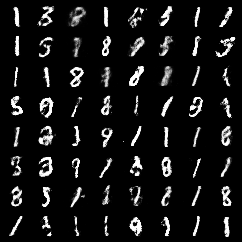

In [ ]:
# train and test gan
epochs = 50

discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []

generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    print(f"Epoch number: {epoch}")
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)

    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)

    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')


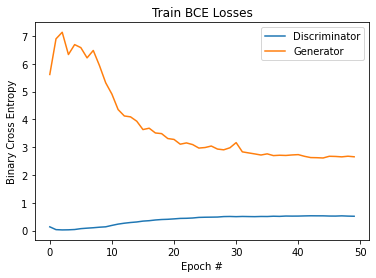

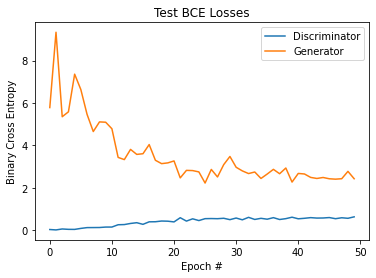

In [ ]:
# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()


## Explanation of the results:


- Looking at the plots, we can confirm that our GAN model training was as expected i.e. initially for both train and test dataset, there are high losses for generator as they are generating images which are not so realistic, and this results in less losses for discriminator as it is easy at that point to identify real vs fake images. However, as our model trains parameters further with more epochs, our generator losses gets lower as it creates more realistic images, and discriminator losses increases because it subsequently finds it more difficult to differentiate between real and fake images. 
- As we know, GAN works on the priciple of game theory, wherein it is minimizing generator and discriminator network losses, and it is a minmax optimization, which requires some art in training the model for optimal performance, otherwise one network will dominate the other. On the other hand, training model with VAE is much easier. But, as we see from the images generated by GAN from test dataset, they are much better than VAE based images.
- It is interesting to note that VAE had generated quite different digits, but they were not very clear, and requires much more training to be more realistic. Whereas when we see GAN based image, we note that it is generating very realisitc images of digits, but currently it is generating certain digits like 1, and 8 much frequently because that helps its generator to fool discrimator much more between real and fake images. However, in order to generate variety of such realistic digits, GAN requires even further training.